# **Group Project: Bricks in the Wall**


## **A Machine learning Study of Student-Teacher Ratios**

Elizabeth Frank & Diana Simonson IST707 ML

---
## **Objective**
---

This project investigates student-teacher ratios across U.S. public schools to identify where staffing disparities are most pronounced and what structural, geographic, and economic conditions contribute to them. While student-teacher ratio is widely recognized as a proxy for educational quality, it is rarely treated as a predictive modeling target—making this an opportunity to surface new insights.

The core objective is to model student-teacher ratios using supervised machine learning, evaluate key drivers through feature importance, and apply unsupervised learning techniques to explore hidden structure in the data. A supplemental analysis will extend this work to a multi-year dataset, enabling us to examine consistency over time and impute missing student-teacher ratios from prior years using trained regressors. Together, these efforts aim to inform data-driven discussions around staffing equity and educational access.

Key stakeholders include students and families—who are directly impacted by class sizes—as well as educators, administrators, and district leaders seeking actionable insights for planning, hiring, and resource allocation.


**Analytical Questions to be answered:**

What kinds of schools are most likely to be under-staffed—and what structural factors drive that?

---
## **Dataset**
---

This project uses a custom-merged dataset built from four NCES EDGE files covering the 2021-2022 school year. The final dataset includes 86,289 public schools in the U.S. and incorporates geographic, demographic, and economic indicators.  

#### Attribute Information:

- **NCESSCH**: Unique 12-digit public school ID  
- **X**: Longitude of the school in decimals  
- **Y**: Latitude of the school in decimals  
- **NAME**: School name  
- **CITY**: City  
- **STATE**: Two-letter state abbreviation  
- **NMCNTY**: County name  
- **CBSATYPE**: Metropolitan or Micropolitan Statistical Area indicator
- **SCHOOLYEAR**: Academic year of data
- **SURVYEAR**: Reporting year for school characteristics  
- **LEAID**: Local Education Agency district ID
- **LEA_NAME**: Name of the school district  
- **VIRTUAL**: Virtual learning status
- **GSLO**: Lowest grade offered by the school  
- **GSHI**: Highest grade offered by the school  
- **SCHOOL_LEVEL**: School level category
- **TITLEI**: Title I eligibility
- **STATUS**: Operational status
- **SCHOOL_TYPE_TEXT**: Descriptive school type
- **ULOCALE**: Urban-centric locale description
- **TOTFRL**: Total students eligible for free or reduced-price lunch  
- **FRELCH**: Number of students eligible for free lunch  
- **REDLCH**: Number of students eligible for reduced-price lunch  
- **PK**: Pre-Kindergarten enrollment count  
- **KG**: Kindergarten enrollment count  
- **G01-G13**: Enrollment counts for Grades 1 through 13  
- **UG**: Ungraded student enrollment  
- **AE**: Adult education enrollment  
- **TOTAL**: Total reported enrollment  
- **FTE**: Full-Time Equivalent teaching staff  
- **MEMBER**: Fall membership count (official enrollment figure)  
- **STUTERATIO**: Student-to-teacher ratio (MEMBER ÷ FTE)  
- **IPR_EST**: Estimated Income-to-Poverty Ratio for school's neighborhood
- **IPR_SE**: Standard error of IPR estimate  
- **LEA_CWIFTEST**: CWIFT score estimating wage competitiveness for teachers in the district  
- **LEA_CWIFTSE**: Standard error of the CWIFT estimate  

---

### **Import Libraries**

In [10]:
# Reading and manipulation of data:
import numpy as np
import pandas as pd
from scipy.stats import ttest_ind

# Data visualization:
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import kaleido
import plotly.io as pio
from IPython.display import Image

# Data Preprocessing
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import SimpleImputer, KNNImputer, IterativeImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, FunctionTransformer
from sklearn.preprocessing import MinMaxScaler, RobustScaler, PowerTransformer

# Modeling
from sklearn.linear_model import Ridge, ElasticNet
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, HistGradientBoostingRegressor
from xgboost import XGBRegressor

# Model Evaluation
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.metrics import mean_absolute_error, median_absolute_error

# Model Tuning
from sklearn.model_selection import cross_val_score, cross_val_predict, KFold
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint
from sklearn.model_selection import GridSearchCV
from itertools import chain

# Unsupervised Learning
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import hdbscan
from sklearn.metrics import silhouette_score

from warnings import filterwarnings
filterwarnings('ignore')

### **Define functions**

In [23]:
# Define a function to provide an overview of the dataframe
def data_overview(df):
    print('Shape of the dataframe:')
    display(df.shape)
    print('First five rows of the dataframe:')
    display(df.head())
    print('Dataframe information, datatypes and missing values:')
    display(df.info())
    print('Duplicate rows in the dataframe:')
    display(df.duplicated().sum())
    print('Unique values in the dataframe:')
    display(df.nunique())
    print('Summary statistics of the dataframe:')
    display(df.describe().T.round(3))

# Define a function for a combination boxplot and histogram
def histogram_boxplot(df, feature, figsize = (8, 4), kde = False, bins = None):
        f2, (ax_box2, ax_hist2) = plt.subplots(
            nrows = 2,
            sharex = True,
            gridspec_kw = {'height_ratios': (0.25, 0.75)},
            figsize = figsize
        )
        sns.boxplot(
            data = df, x = feature, ax = ax_box2, showmeans = True, color = 'violet'
        )
        sns.histplot(
            data = df, x = feature, kde = kde, ax = ax_hist2, bins = bins if bins else 'auto'
        )
        ax_hist2.axvline(df[feature].mean(), color = 'green', linestyle = '--')
        ax_hist2.axvline(df[feature].median(), color = 'black', linestyle = '-')
        plt.tight_layout()
        plt.show()


# Define a function to visualize faceted CWIFT scores and student-teacher ratios
def plot_facet(data, facet_col):
    g = sns.FacetGrid(data, col=facet_col, col_wrap=3, height=4, sharey=False)
    g.map_dataframe(sns.scatterplot, x="LEA_CWIFTEST", y="STUTERATIO", alpha=0.3)
    g.set_titles(f"{facet_col}: {{col_name}}")
    g.set_axis_labels("LEA_CWIFTEST", "Student-Teacher Ratio")
    plt.tight_layout()
    plt.show()


# Define a function for a boxplot or attributes split by TITLEI
def boxplot_titlei(data, y_col, y_label=None, palette='Set2'):
    sns.boxplot(x='TITLEI', y=y_col, data=data, palette=palette)
    plt.title(f'{y_col} by TITLEI Status')
    plt.xlabel('TITLEI')
    plt.ylabel(y_label if y_label else y_col)
    plt.tight_layout()
    plt.show()


# Define a function for stacked bar plots of the states
def plot_state_stacked_bars(df, columns, figsize=(14, 6)):
    for col in columns:
        counts = (
            df.groupby(['STATE', col])
            .size()
            .unstack(fill_value=0)
            .sort_index()
        )
        counts.plot(kind='bar', stacked=True, figsize=figsize, colormap='Set2')
        plt.title(f'Schools by {col} per State')
        plt.ylabel('Number of Schools')
        plt.xlabel('State')
        plt.legend(title=col)
        plt.xticks(rotation=90)
        plt.tight_layout()
        plt.show()


# Define a pipeline for modeling
def build_model_pipeline(model, imputer=None, scaler=None):
    imputer = imputer or SimpleImputer(strategy='median')
    scaler = scaler or StandardScaler()

    log_transform_features = ['IPR_EST', 'frl_rate', 'redl_rate']
    passthrough_features = ['LEA_CWIFTEST', 'total_grades']
    categorical_features = ['CBSATYPE', 'VIRTUAL', 'SCHOOL_LEVEL', 'TITLEI', 'ULOCALE']

    log_numeric_transformer = Pipeline([
        ('imputer', imputer),
        ('log', FunctionTransformer(np.log1p, validate=False)),
        ('scaler', scaler)
    ])
    passthrough_numeric_transformer = Pipeline([
        ('imputer', imputer),
        ('scaler', scaler)
    ])
    categorical_transformer = Pipeline([
        ('imputer', SimpleImputer(strategy='constant', fill_value='Missing')),
        ('encoder', OneHotEncoder(handle_unknown='ignore'))
    ])
    preprocessor = ColumnTransformer([
        ('log_num', log_numeric_transformer, log_transform_features),
        ('num', passthrough_numeric_transformer, passthrough_features),
        ('cat', categorical_transformer, categorical_features)
    ])
    return Pipeline([
        ('preprocessor', preprocessor),
        ('regressor', model)
    ])


# Define a function that evaluates the models metrics
def evaluate_model(pipeline, X_train, y_train_log, label):
    # Fit the model on log transformed target
    pipeline.fit(X_train, y_train_log)

    # Predict in log scale
    y_pred_log = pipeline.predict(X_train)

    # Inverse log1p to return to original STUTERATIO scale
    y_pred = np.expm1(y_pred_log)
    y_actual = np.expm1(y_train_log)

    return {
        'Model': label,
        'R²': r2_score(y_actual, y_pred),
        'RMSE': mean_squared_error(y_actual, y_pred),
        'MAE': mean_absolute_error(y_actual, y_pred),
        'MedianAE': np.median(np.abs(y_actual - y_pred))
    }

### **Import data**

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
# Data loading utlizing function
edu_qual_data = pd.read_csv('/content/drive/MyDrive/USEducation/2021_Merged_School_Data/Merged_school_data_2021_2022.csv')

In [6]:
# Create a cody
edu_qual_df = edu_qual_data.copy()

### **Exploratory Data Anaylsis**

In [106]:
# Check data shape
edu_qual_df.shape

(102130, 48)

In [28]:
# View the first five rows of the dataframe
edu_qual_df.head()

NCESSCH          X        Y                               NAME  \
0  10000500870 -86.206200  34.2602          Albertville Middle School   
1  10000500871 -86.204900  34.2622            Albertville High School   
2  10000500879 -86.220100  34.2733    Albertville Intermediate School   
3  10000500889 -86.221806  34.2527      Albertville Elementary School   
4  10000501616 -86.193300  34.2898  Albertville Kindergarten and PreK   

          CITY STATE           NMCNTY  CBSATYPE SCHOOLYEAR   SURVYEAR  ...  \
0  Albertville    AL  Marshall County         2  2021-2022  2021-2022  ...   
1  Albertville    AL  Marshall County         2  2021-2022  2021-2022  ...   
2  Albertville    AL  Marshall County         2  2021-2022  2021-2022  ...   
3  Albertville    AL  Marshall County         2  2021-2022  2021-2022  ...   
4  Albertville    AL  Marshall County         2  2021-2022  2021-2022  ...   

   UG  AE   TOTAL    FTE  MEMBER STUTERATIO IPR_EST  IPR_SE LEA_CWIFTEST  \
0 NaN NaN   920.0  32.50   920.0      28.31   206.0    42.0         0.76   
1 NaN NaN  1665.0  82.00  1665.0      20.30   201.0    43.0         0.76   
2 NaN NaN   924.0  39.00   924.0      23.69   164.0    43.0         0.76   
3 NaN NaN   891.0  43.00   891.0      20.72   225.0    54.0         0.76   
4 NaN NaN   579.0  25.25   579.0      22.93   278.0    93.0         0.76   

  LEA_CWIFTSE  
0       0.029  
1       0.029  
2       0.029  
3       0.029  
4       0.029  

[5 rows x 48 columns]

In [29]:
# View the last five rows of the data frame
edu_qual_df.tail()

NCESSCH          X          Y                             NAME  \
102125  780003000024 -64.917602  18.341950       LOCKHART ELEMENTARY SCHOOL   
102126  780003000026 -64.952483  18.338742  ULLA F MULLER ELEMENTARY SCHOOL   
102127  780003000027 -64.899024  18.354782  YVONNE BOWSKY ELEMENTARY SCHOOL   
102128  780003000033 -64.945940  18.336658       CANCRYN JUNIOR HIGH SCHOOL   
102129  780003000034 -64.890311  18.318230     BERTHA BOSCHULTE JUNIOR HIGH   

                CITY STATE             NMCNTY  CBSATYPE SCHOOLYEAR   SURVYEAR  \
102125  Saint Thomas    VI  St. Thomas Island         0  2021-2022  2021-2022   
102126  Saint Thomas    VI  St. Thomas Island         0  2021-2022  2021-2022   
102127  Saint Thomas    VI  St. Thomas Island         0  2021-2022  2021-2022   
102128  Saint Thomas    VI  St. Thomas Island         0  2021-2022  2021-2022   
102129  Saint Thomas    VI  St. Thomas Island         0  2021-2022  2021-2022   

        ...  UG  AE  TOTAL   FTE MEMBER STUTERATIO IPR_EST  IPR_SE  \
102125  ... NaN NaN  284.0  24.0  284.0      11.83     NaN     NaN   
102126  ... NaN NaN  437.0  27.0  437.0      16.19     NaN     NaN   
102127  ... NaN NaN  381.0  32.0  381.0      11.91     NaN     NaN   
102128  ... NaN NaN  744.0  62.0  744.0      12.00     NaN     NaN   
102129  ... NaN NaN  515.0  47.0  515.0      10.96     NaN     NaN   

       LEA_CWIFTEST LEA_CWIFTSE  
102125          NaN         NaN  
102126          NaN         NaN  
102127          NaN         NaN  
102128          NaN         NaN  
102129          NaN         NaN  

[5 rows x 48 columns]

In [30]:
# Check the datatypes and missing variable counts
edu_qual_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 102130 entries, 0 to 102129
Data columns (total 48 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   NCESSCH           102130 non-null  int64  
 1   X                 102130 non-null  float64
 2   Y                 102130 non-null  float64
 3   NAME              102130 non-null  object 
 4   CITY              102130 non-null  object 
 5   STATE             102130 non-null  object 
 6   NMCNTY            102130 non-null  object 
 7   CBSATYPE          102130 non-null  int64  
 8   SCHOOLYEAR        102130 non-null  object 
 9   SURVYEAR          101278 non-null  object 
 10  LEAID             101278 non-null  float64
 11  LEA_NAME          101278 non-null  object 
 12  VIRTUAL           101278 non-null  object 
 13  GSLO              101278 non-null  object 
 14  GSHI              101278 non-null  object 
 15  SCHOOL_LEVEL      101278 non-null  object 
 16  TITLEI            10

In [31]:
# Confirm that there are no duplicate rows in the dataframe
edu_qual_df.duplicated().sum()

np.int64(0)

In [32]:
# Determine the number of unique values in each attribute
edu_qual_df.nunique()

NCESSCH             102130
X                    91000
Y                    89112
NAME                 90114
CITY                 14644
STATE                   56
NMCNTY                1963
CBSATYPE                 3
SCHOOLYEAR               1
SURVYEAR                 1
LEAID                18441
LEA_NAME             18115
VIRTUAL                  6
GSLO                    18
GSHI                    19
SCHOOL_LEVEL            10
TITLEI                   4
STATUS                   7
SCHOOL_TYPE_TEXT         4
ULOCALE                 12
TOTFRL                1939
FRELCH                1803
REDLCH                 412
PK                     404
KG                     409
G01                    364
G02                    362
G03                    373
G04                    397
G05                    496
G06                    613
G07                    666
G08                    688
G09                   1005
G10                    952
G11                    917
G12                    909
G13                     41
UG                     213
AE                      20
TOTAL                 2986
FTE                  10527
MEMBER                2985
STUTERATIO            3875
IPR_EST                938
IPR_SE                 308
LEA_CWIFTEST           448
LEA_CWIFTSE             89
dtype: int64

**Observation:**

The dataset contains 102,130 rows and 48 columns, a comprehensive snapshot of public school data for the 2021-2022 school year. After reviewing the structure, many of the core features required for modeling, such as FTE, MEMBER, STUTERATIO, LEA_CWIFTEST, and lunch eligibility counts, contain some level of missing, which will need to be addressed either through imputation or filtering. A closer look at unique values confirms broad geographic and structural coverage, including 56 distinct states and territories, 18,000+ LEAIDs, and 10 school level groupings.

In [7]:
# Create grade level totals
edu_qual_df['total_prek'] = edu_qual_df[['PK']].sum(axis=1)
edu_qual_df['total_elem'] = edu_qual_df[['KG', 'G01', 'G02', 'G03', 'G04', 'G05']].sum(axis=1)
edu_qual_df['total_middle'] = edu_qual_df[['G06', 'G07', 'G08']].sum(axis=1)
edu_qual_df['total_high'] = edu_qual_df[['G09', 'G10', 'G11', 'G12', 'G13']].sum(axis=1)

# Count total non-null grade columns
grade_cols = ['PK', 'KG', 'G01', 'G02', 'G03', 'G04', 'G05',
              'G06', 'G07', 'G08', 'G09', 'G10', 'G11', 'G12', 'G13']
edu_qual_df['total_grades'] = edu_qual_df[grade_cols].notna().sum(axis=1)

# Drop individual grade columns and special grades
edu_qual_df = edu_qual_df.drop(columns=grade_cols + ['AE', 'UG'], errors='ignore')

# Keep only standard PreK–13 school levels
k13_levels = ['Elementary', 'Middle', 'High', 'Secondary']
edu_qual_df = edu_qual_df[edu_qual_df['SCHOOL_LEVEL'].isin(k13_levels)].copy()

# Remove non regular schools and filter to only open schools
edu_qual_df = edu_qual_df[edu_qual_df['SCHOOL_TYPE_TEXT'].isin(['Regular school', 'Alternative Education School'])].reset_index(drop=True)
edu_qual_df = edu_qual_df[edu_qual_df['STATUS'] == 1.0]

# Drop virtual formats that don’t reflect true staffing ratios
edu_qual_df = edu_qual_df[~edu_qual_df['VIRTUAL'].isin(['Full Virtual', 'Virtual with face to face options'])]

# Drop rows with missing target (student-teacher ratio)
edu_qual_df = edu_qual_df.dropna(subset=['STUTERATIO'])

# Drop specific territories lacking external poverty data
edu_qual_df = edu_qual_df[~edu_qual_df['STATE'].isin(['GU', 'MP', 'PR', 'VI'])]

# Drop constants, filtered out, and redundant attributes
edu_qual_df = edu_qual_df.drop(columns=[
    'SURVYEAR', 'SCHOOL_TYPE_TEXT', 'SCHOOLYEAR', 'STATUS',
    'GSLO', 'GSHI',
    'TOTAL', 'IPR_SE', 'LEA_CWIFTSE',
], errors='ignore')

# Create a free or reduced lunch rate features
edu_qual_df['frl_rate'] = edu_qual_df['TOTFRL'] / edu_qual_df['MEMBER']
edu_qual_df['redl_rate'] = edu_qual_df['REDLCH'] / edu_qual_df['MEMBER']
edu_qual_df.drop(columns=['FRELCH', 'REDLCH', 'TOTFRL'], inplace=True)

**Explanation:**

This series of transformations was designed to create a cleaner, more analytically useful version of the dataset by consolidating grade level data, filtering to relevant school types, and engineering new features for modeling.

The first step aggregated student counts into grouped grade bands, pre-kindergarten, elementary, middle, and high school, making it easier to interpret enrollment by developmental stage. A new total_grades feature was also calculated to indicate how many distinct grade levels each school served.

To streamline the dataset, individual grade level columns and special education types like adult and ungraded students were dropped to reduce noise and missing values not relevant to the modeling objective. The focus was then narrowed to standard school levels, Elementary, Middle, High, Secondary to ensure consistency across observations. Schools with non-standard types, closed status, or fully virtual instruction were also removed, since such records may distort metrics like student-teacher ratio or lack comparable structure.

Territories such as Guam, Puerto Rico, and the Virgin Islands were excluded due to inconsistent availability of poverty data. Several fields that were constant, redundant, or no longer necessary after transformation, like SURVYEAR, SCHOOLYEAR, and TOTAL, were dropped. Finally, free and reduced lunch rates, frl_rate and redl_rate were computed as proportions of total enrollment, offering normalized indicators of economic disadvantage. These changes collectively refined the dataset into a well structured foundation for both supervised and unsupervised learning.

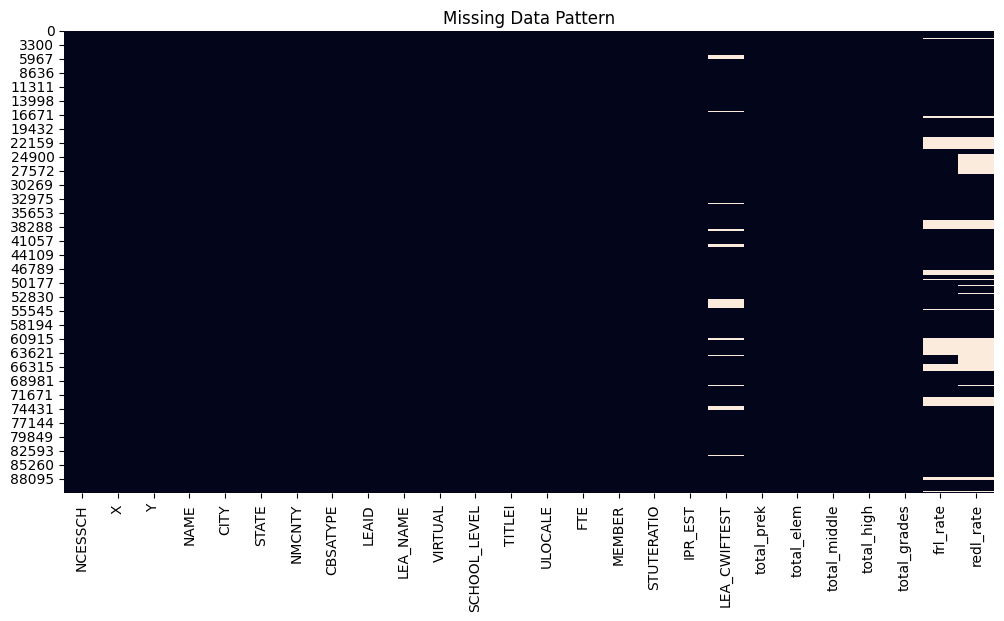

In [34]:
# Visualize the NaN in dataset (doesn't include 'missing' data)
missing_summary = edu_qual_df.isna().sum().to_frame(name='missing_count')
missing_summary['missing_pct'] = (missing_summary['missing_count'] / len(edu_qual_df)) * 100
missing_summary = missing_summary[missing_summary['missing_count'] > 0].sort_values(by='missing_pct', ascending=False)
missing_summary

plt.figure(figsize=(12, 6))
sns.heatmap(edu_qual_df.isnull(), cbar=False)
plt.title("Missing Data Pattern")
plt.show()

**Observation:**

The missing data summary reveals that only a small subset of features have NaN values after filtering and cleaning. Most fields are nearly complete, with only a few including FTE, LEAID, LEA_NAME, and LEA_CWIFTEST showing moderate gaps. This supports the decision to proceed with imputation strategies where appropriate.

In [35]:
# Checking statistical summary of numerical attributes
stat_cols = [
    'FTE', 'MEMBER', 'STUTERATIO',
    'IPR_EST', 'total_prek', 'LEA_CWIFTEST',
    'total_elem', 'total_middle', 'total_high',
    'total_grades', 'frl_rate', 'redl_rate'
]

edu_qual_df[stat_cols].describe().round(2).T

count    mean     std    min     25%     50%     75%      max
FTE           86289.0   34.35   25.29   0.04   19.00   29.00   42.06   332.31
MEMBER        86289.0  528.02  437.43   0.00  275.00  433.00  640.00  5966.00
STUTERATIO    86289.0   15.56   29.72   0.00   12.27   14.63   17.52  7766.67
IPR_EST       86289.0  327.10  158.93  32.00  219.00  286.00  390.00   990.00
total_prek    86289.0   11.53   25.22   0.00    0.00    0.00   14.00   506.00
LEA_CWIFTEST  80151.0    0.94    0.12   0.59    0.85    0.91    1.02     1.43
total_elem    86289.0  230.48  238.35   0.00    0.00  199.00  404.00  3715.00
total_middle  86289.0  121.46  251.91   0.00    0.00    0.00  100.00  2655.00
total_high    86289.0  163.70  468.08   0.00    0.00    0.00    0.00  5965.00
total_grades  86289.0    5.53    2.07   1.00    4.00    6.00    7.00    14.00
frl_rate      72922.0    0.53    0.28   0.00    0.30    0.51    0.77     1.50
redl_rate     67218.0    0.04    0.05   0.00    0.01    0.03    0.07     0.98

**Observation:**

The summary statistics show high variability across key numerical features. STUTERATIO has a wide range, with some extreme outliers visible in the maximum value over 7700, likely a reflection of data entry issues. Central tendency measures suggest a fairly typical student-teacher ratio in the mid-teens. IPR_EST spans from 32 to nearly 1000, indicating that the dataset includes schools serving both very low income and relatively affluent communities. Grade level totals show that most schools serve between 4 and 7 grades, and average number of full time staff and enrolled students varies significantly. Both lunch rate variables display skewness, with many schools showing low or zero redl_rate, indicators of economic need. Overall, the distributions are consistent with expectations and reinforce the importance of log transformation and scaling.

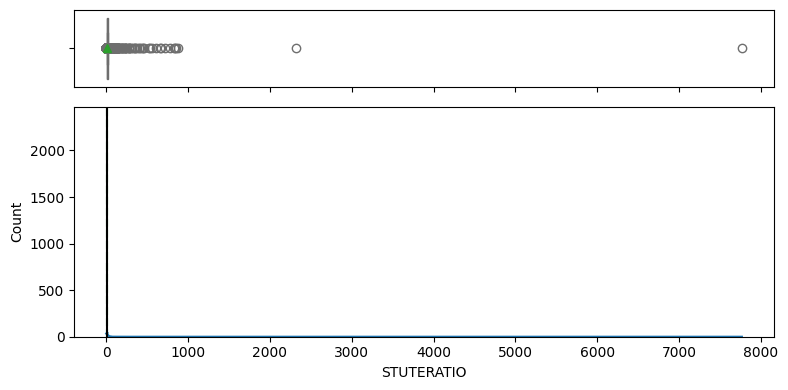

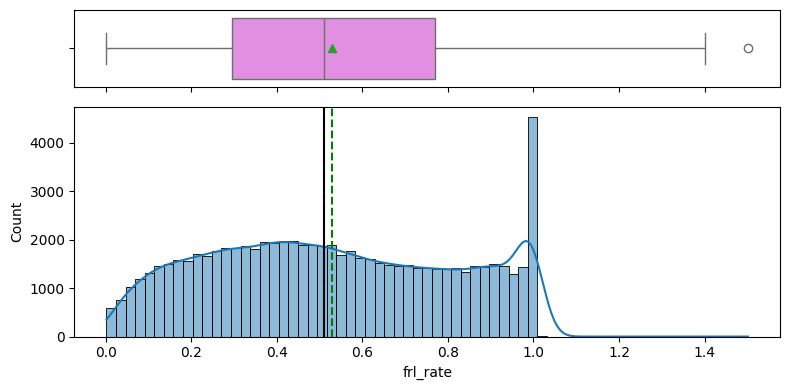

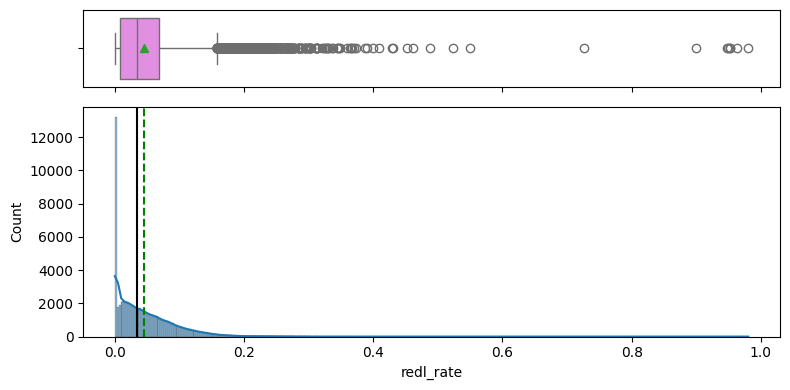

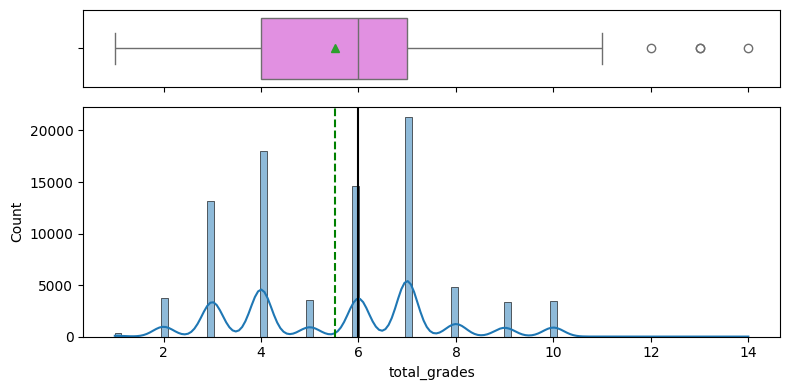

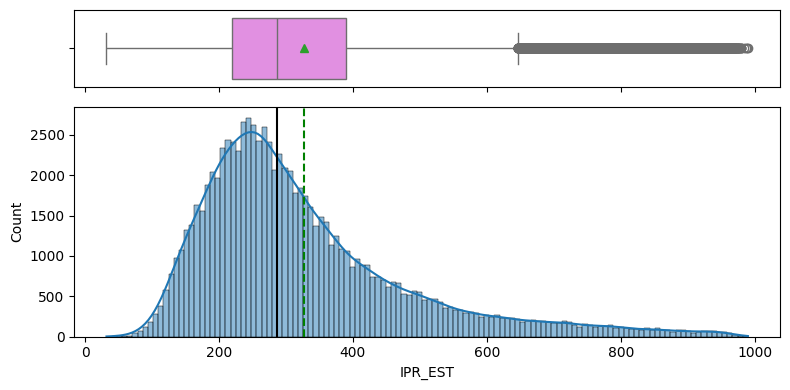

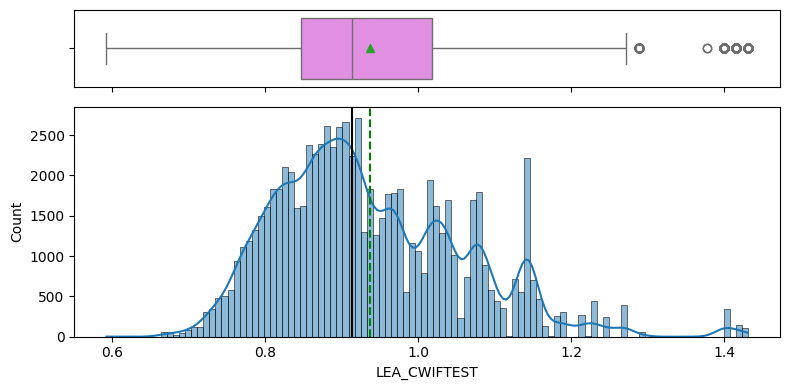

In [36]:
# Visualize STUTERATIO, free lunch rate, reduced lunch rate, total grades,
# income to poverty, and CWIFT score distribution
histogram_boxplot(edu_qual_df, 'STUTERATIO', kde=True)
histogram_boxplot(edu_qual_df, 'frl_rate', kde=True)
histogram_boxplot(edu_qual_df, 'redl_rate', kde=True)
histogram_boxplot(edu_qual_df, 'total_grades', kde=True)
histogram_boxplot(edu_qual_df, 'IPR_EST', kde=True)
histogram_boxplot(edu_qual_df, 'LEA_CWIFTEST', kde=True)

**Obervation:**

STUTERATIO is heavily right-skewed with a small number of extreme outliers, including some values exceeding 7000, which will be addressed, including the need for log transformation. Both frl_rate and redl_rate exhibit strong skewness, with frl_rate clustering near zero and one, indicating a polarized distribution of economic disadvantage across schools. redl_rate is sharply concentrated near zero, suggesting that most qualifying students fall into the fully subsidized category rather than reduced price.

The total_grades variable shows a multimodal distribution with peaks at common school structures, such as schools offering exactly five or six grades. This variation in school structure could influence staffing and student distribution. IPR_EST is positively skewed, with a long tail extending toward higher income-to-poverty ratios, reinforcing its importance as a normalization candidate. LEA_CWIFTEST is generally symmetric but shows more granularity in the mid-to-low range, hinting at regional disparities in teacher wage competitiveness.

In [37]:
# Display rows with extreme student-teacher ratios
over_1000 = edu_qual_df[edu_qual_df['STUTERATIO'] > 500]
display(over_1000[['NAME', 'CITY', 'STATE', 'MEMBER', 'FTE', 'STUTERATIO']])

equal_0 = edu_qual_df[edu_qual_df['STUTERATIO'] == 0]
display(equal_0[['NAME', 'CITY', 'STATE', 'MEMBER', 'FTE', 'STUTERATIO']])

NAME           CITY STATE  MEMBER   FTE  \
19853             MATER PALMS ACADEMY      KISSIMMEE    FL   858.0  1.00   
25073              Alcott Elem School        Chicago    IL   610.0  1.00   
25164               Mason Elem School        Chicago    IL   270.0  0.50   
25430           Disney II Elem School        Chicago    IL   416.0  0.50   
26813    Morrisonville Jr High School  Morrisonville    IL    44.0  0.05   
28723          South Creek Elementary   Indianapolis    IN   655.0  1.00   
40756                       WAY Niles          NILES    MI   143.0  0.20   
42412          BROWERVILLE ELEMENTARY    BROWERVILLE    MN   261.0  0.50   
52486           EARLY COLLEGE ACADEMY    ALBUQUERQUE    NM   201.0  0.30   
52912  ARROWHEAD PARK MEDICAL ACADEMY     LAS CRUCES    NM   232.0  0.10   
56212     LOCUST VALLEY MIDDLE SCHOOL  LOCUST VALLEY    NY   466.0  0.06   
58003     Niner University Elementary      Charlotte    NC   117.0  0.14   
71947  Cornerstone Prep Denver Campus        Memphis    TN   557.0  1.00   
89448      Carmen Hi Southeast Campus      Milwaukee    WI   785.0  1.00   

       STUTERATIO  
19853      858.00  
25073      610.00  
25164      540.00  
25430      832.00  
26813      880.00  
28723      655.00  
40756      715.00  
42412      522.00  
52486      670.00  
52912     2320.00  
56212     7766.67  
58003      835.71  
71947      557.00  
89448      785.00

NAME               CITY STATE  \
2349             Ken 'Chief' Hill Learning Academy           CHANDLER    AZ   
2721                     Underdown Learning Center           AVONDALE    AZ   
2846             Jordan Center for Early Education           CHANDLER    AZ   
3105                        Amy L. Houston Academy            PHOENIX    AZ   
3681        CSTP-CIVILIAN STUDENT TRAINING PROGRAM  NORTH LITTLE ROCK    AR   
...                                            ...                ...   ...   
85778  Island Juvenile Detention Education Program         Coupeville    WA   
85822                      Easton Secondary School             Easton    WA   
86454                    Mount Adams Middle School         White Swan    WA   
88676                         Oxford Avenue School         Eau Claire    WI   
89177              Innovative & Alternative Middle            Madison    WI   

       MEMBER        FTE  STUTERATIO  
2349      0.0  17.200001         0.0  
2721      0.0   1.000000         0.0  
2846      0.0   7.200000         0.0  
3105      0.0  13.000000         0.0  
3681      0.0   4.060000         0.0  
...       ...        ...         ...  
85778     0.0   1.000000         0.0  
85822     0.0   3.710000         0.0  
86454     0.0   6.930000         0.0  
88676     0.0   1.500000         0.0  
89177     0.0   6.000000         0.0  

[300 rows x 6 columns]

In [8]:
# Drop extreme and unlikely student-teacher ratios
edu_qual_df = edu_qual_df[edu_qual_df['STUTERATIO'] < 80].copy()
edu_qual_df = edu_qual_df[edu_qual_df['STUTERATIO'] > 1].copy()
edu_qual_df.reset_index(drop=True, inplace=True)

**Explanation:**

This step removes schools with extreme or invalid student-teacher ratios, typically caused by unusually low or zero FTE values. Ratios above 500 or equal to zero are not representative of standard instructional environments and often reflect reporting issues or non-traditional settings. Filtering to values between 1 and 80 retains realistic observations, while still being conservative, to improves model reliability.

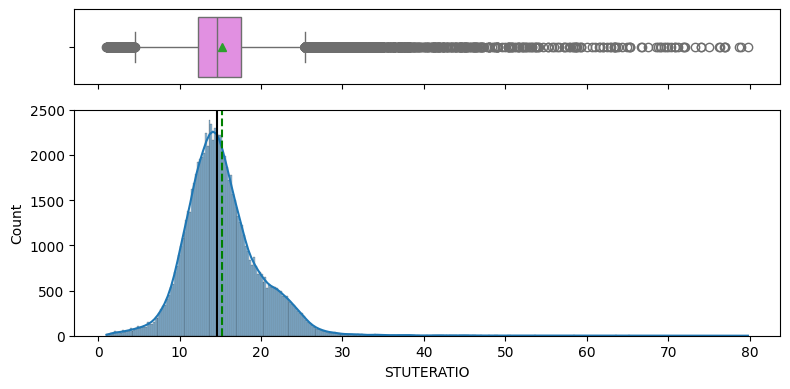

In [39]:
# Visualize new STUTERATIO distribution
histogram_boxplot(edu_qual_df, 'STUTERATIO', kde=True)

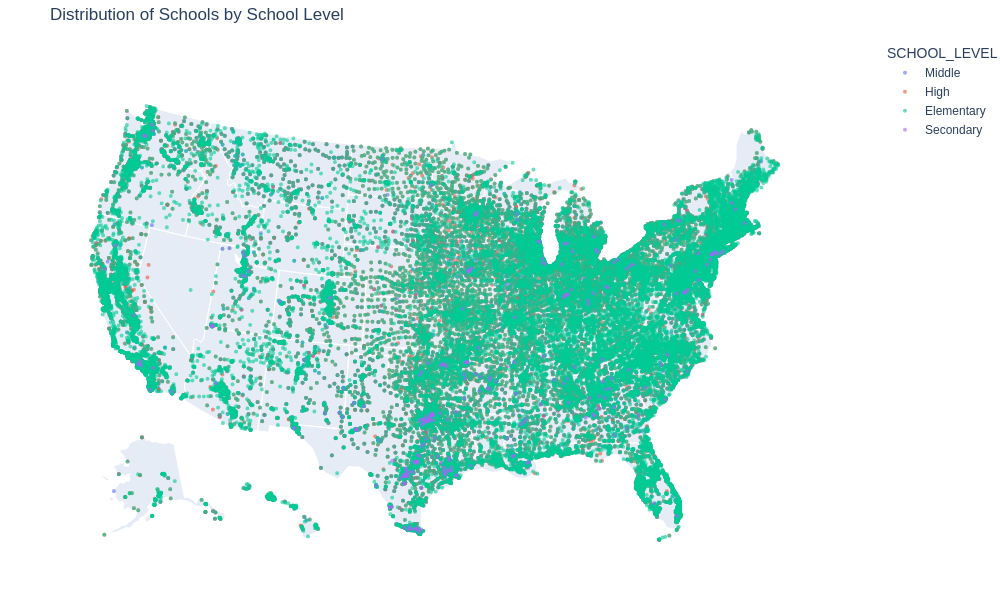

In [12]:
# Plot school and school level by latitude and longitude
fig = px.scatter_geo(
    edu_qual_df,
    lon='X',
    lat='Y',
    color='SCHOOL_LEVEL',
    hover_name='NAME',
    hover_data={'STATE': True, 'CITY': True, 'STUTERATIO': True},
    opacity=0.6,
    title='Distribution of Schools by School Level',
    projection='albers usa',
    width=1000,
    height=600
)
fig.update_traces(marker=dict(size=4))
fig.update_layout(margin={"r":0,"t":40,"l":0,"b":0})
pio.write_image(fig, "level_map.png")
Image("level_map.png")

**Observation:**

The geographic distribution shows strong school coverage across all regions, with a high concentration of elementary schools throughout the eastern U.S., more sparse placement in the West, and denser clusters near urban centers reflecting higher populations. With the dataset's national scope it highlights potential geographic differences in school structure and staffing.

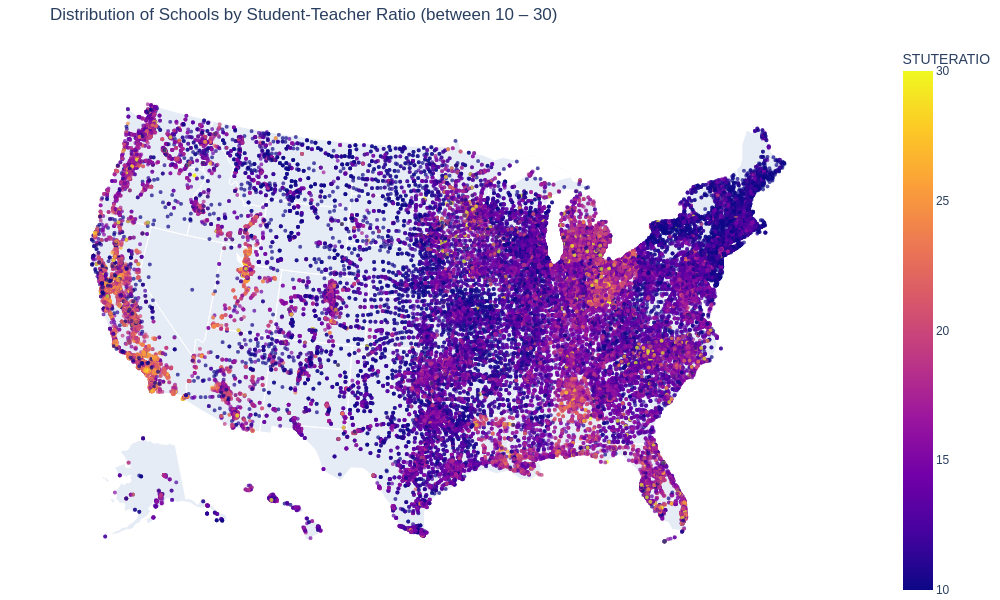

In [13]:
# Plot school and student-teacher ratio by latitude and longitude
fig = px.scatter_geo(
    edu_qual_df,
    lon='X',
    lat='Y',
    color='STUTERATIO',
    hover_name='NAME',
    hover_data={'STATE': True, 'CITY': True, 'SCHOOL_LEVEL': True, 'STUTERATIO': True},
    opacity=0.7,
    title= 'Distribution of Schools by Student-Teacher Ratio (between 10 – 30)',
    projection='albers usa',
    width=1000,
    height=600,
    color_continuous_scale='Plasma',
    range_color=(10, 30)
)
fig.update_traces(marker=dict(size=4))
fig.update_layout(margin={"r":0,"t":40,"l":0,"b":0})
pio.write_image(fig, "str_map.png")
Image("str_map.png")


The map shows clear regional variation in student-teacher ratios across schools with values culled between 10 and 30. The clustering patterns suggest that staffing levels may be influenced by regional policies, funding environments, or population density. Higher ratios, indicated by warmer colors, are more common along the West Coast and parts of the Southeast, while lower ratios appear more frequently in the Midwest and Northeast. California, and possibly Ohio and Alabama, stand out with consistently higher student-teacher ratios, pointing to statewide trends rather than isolated cases.

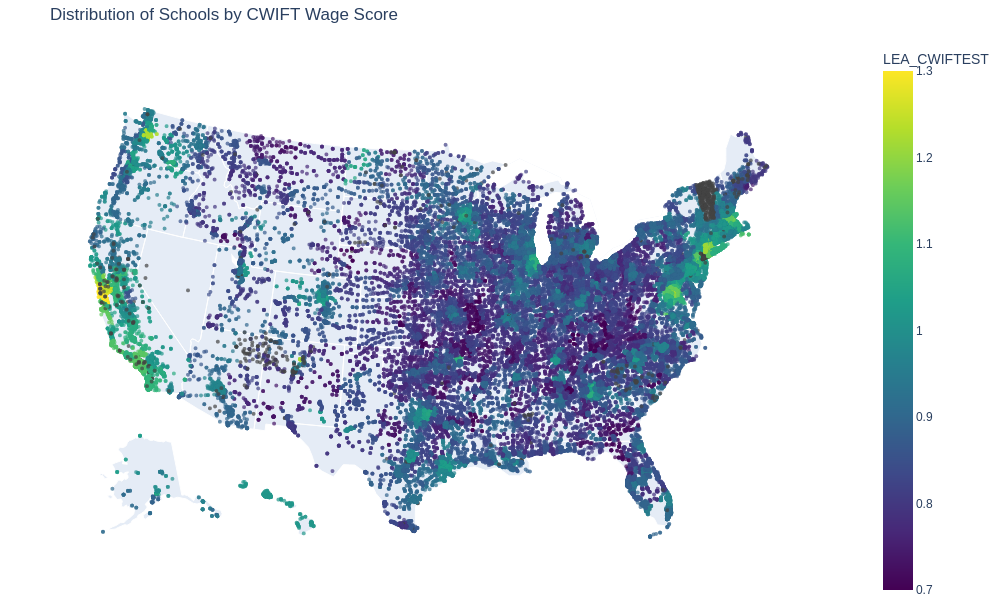

In [14]:
# Plot school and CWIFT score by latitude and longitude
fig = px.scatter_geo(
    edu_qual_df,
    lon='X',
    lat='Y',
    color='LEA_CWIFTEST',
    hover_name='NAME',
    hover_data={'STATE': True, 'CITY': True, 'SCHOOL_LEVEL': True, 'LEA_CWIFTEST': True},
    opacity=0.7,
    title='Distribution of Schools by CWIFT Wage Score',
    projection='albers usa',
    width=1000,
    height=600,
    color_continuous_scale='Viridis',
    range_color=(0.7, 1.3)
)
fig.update_traces(marker=dict(size=4))
fig.update_layout(margin={"r":0,"t":40,"l":0,"b":0})
pio.write_image(fig, "cwift_map.png")
Image("cwift_map.png")

**Observation:**

The CWIFT wage competitiveness map shows clear geographic variation, with higher scores indicating more competitive teacher wages, clustered in California, parts of the Northeast, and select urban areas across the country. Much of the South and Midwest shows lower scores, suggesting regional wage disparities that could influence teacher recruitment and retention. California again stands out, especially along the coast, where many schools appear in the top competitiveness tier. These patterns highlight the importance of accounting for regional wage context with variables like student-teacher ratio.

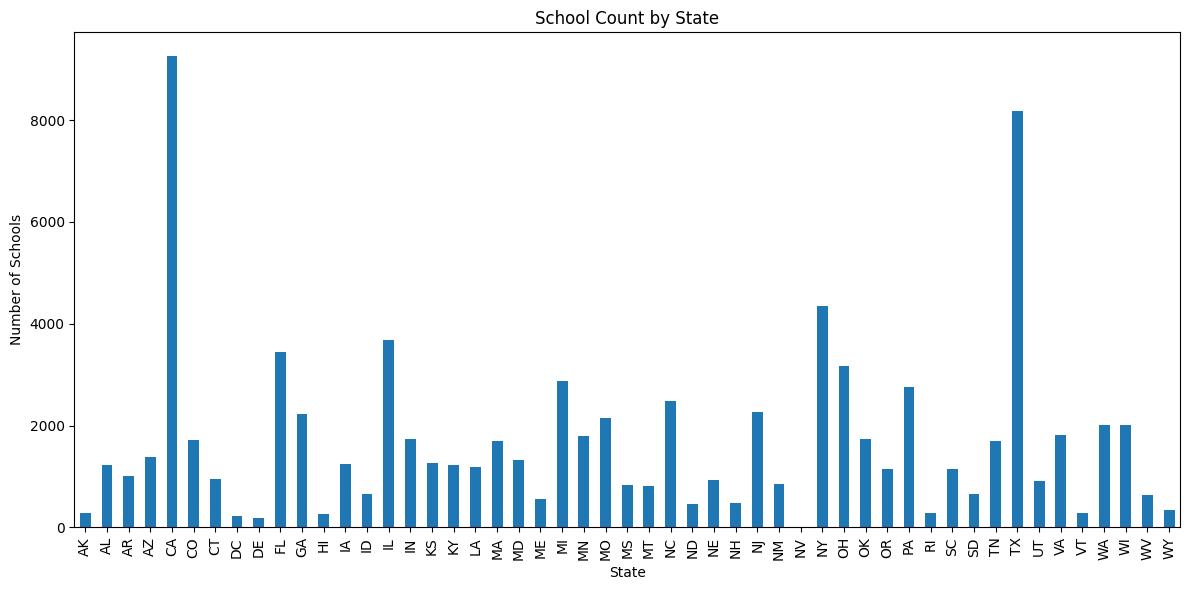

In [43]:
# Number of schools per state
plt.figure(figsize=(12, 6))
edu_qual_df['STATE'].value_counts().sort_index().plot(kind='bar')

plt.title('School Count by State')
plt.xlabel('State')
plt.ylabel('Number of Schools')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

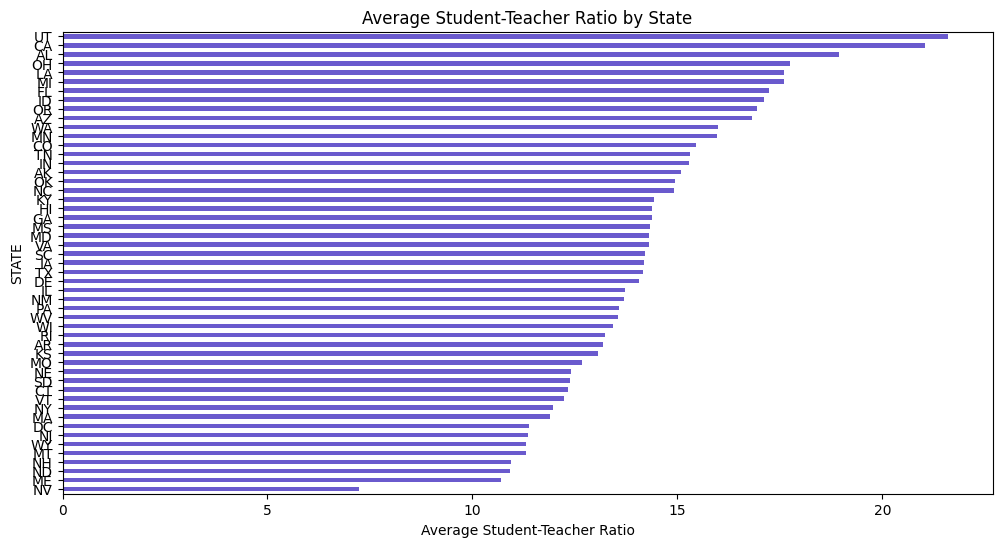

In [44]:
# Average student-teacher ratio by state
plt.figure(figsize=(12, 6))
state_avg_ratio = edu_qual_df.groupby('STATE')['STUTERATIO'].mean().sort_values()
state_avg_ratio.plot(kind='barh', color='slateblue')
plt.xlabel('Average Student-Teacher Ratio')
plt.title('Average Student-Teacher Ratio by State')
plt.show()

**Observation:**

Counts indicate Texas and California have the highest number of schools in the dataset by a wide margin, which aligns with their large populations. The average student-teacher ratios shows Utah and California reporting the highest averages nationally. Having Texas not appear at the top of the ratio ranking, suggests that factors beyond enrollment volume, such as policy, funding, or regional cost of living, might play a role in shaping staffing levels.

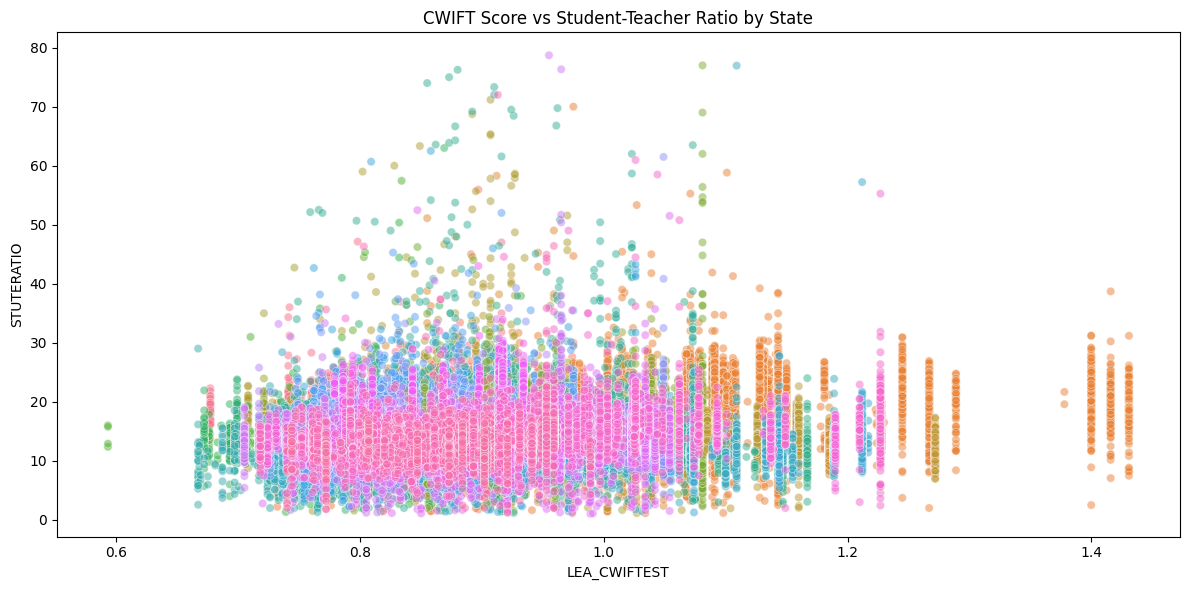

In [45]:
# Relationship between CWIFT score, student-teacher ratio, and state by color
plt.figure(figsize=(12, 6))
sns.scatterplot(x='LEA_CWIFTEST', y='STUTERATIO', hue='STATE', data=edu_qual_df, alpha=0.5, legend=False)
plt.title("CWIFT Score vs Student-Teacher Ratio by State")
plt.xlabel("LEA_CWIFTEST")
plt.ylabel("STUTERATIO")
plt.tight_layout()
plt.show()

**Observation:**

The scatterplot shows no strong linear relationship between CWIFT wage scores and student-teacher ratios. Schools with higher CWIFT values still display a wide spread of ratios, suggesting that competitive wages alone do not consistently correspond to lower staffing ratios. The vertical clustering by state indicates variation is more structured by state context than by CWIFT score alone.

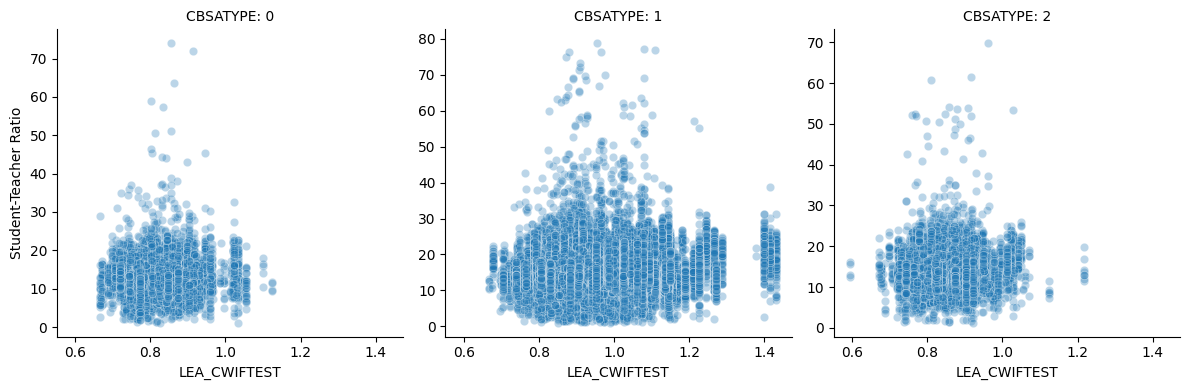

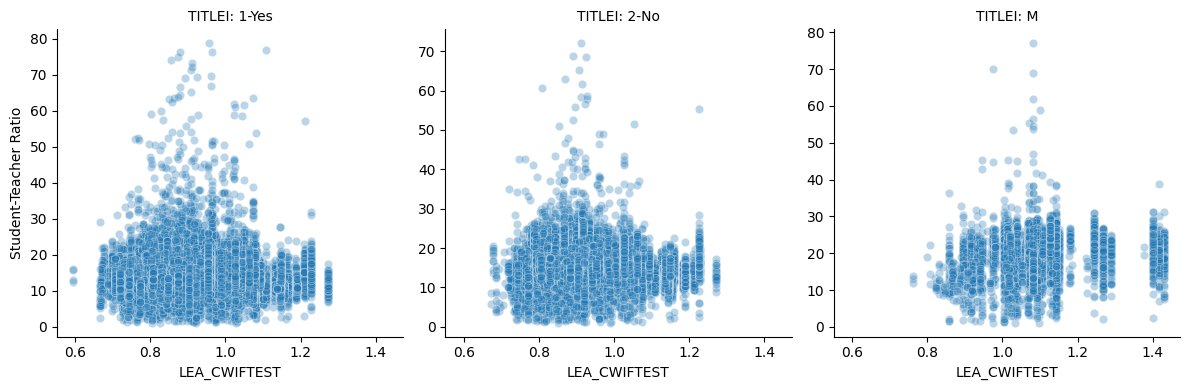

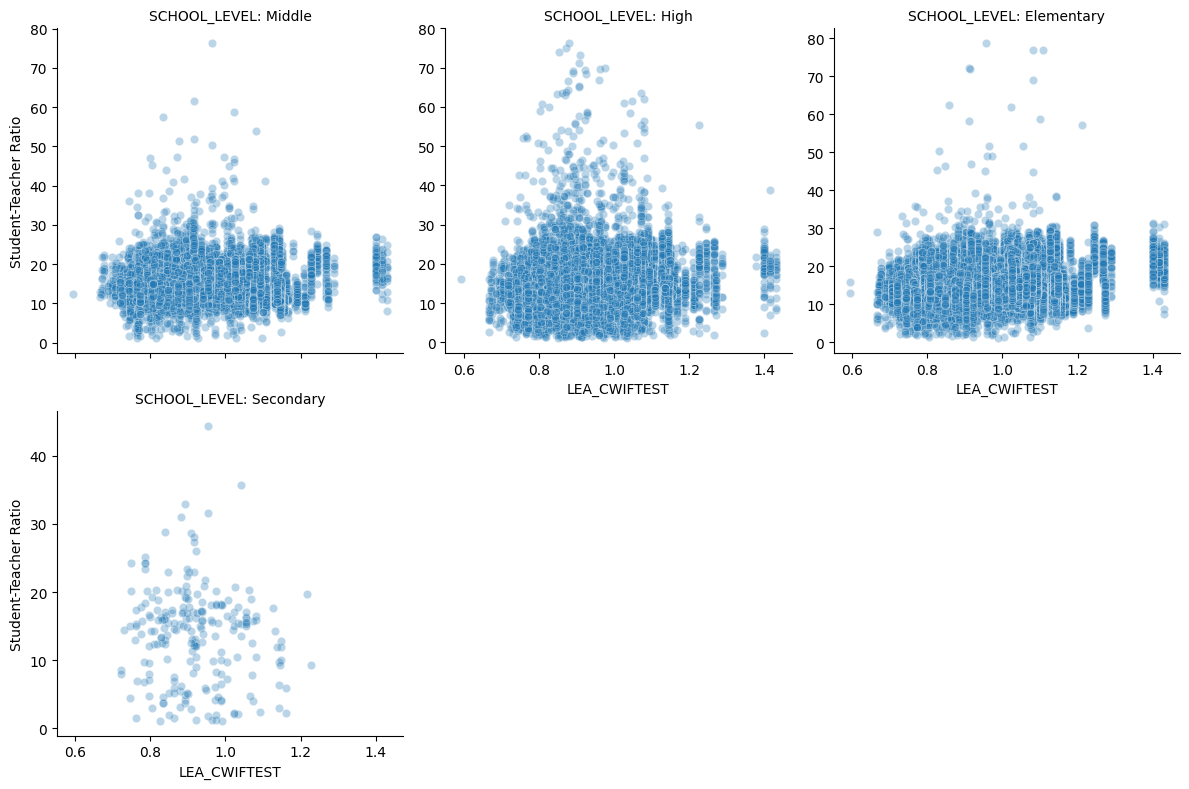

In [46]:
# Relationship between CWIFT score and student-teacher ratio faceted by CBSATYPE
# TITLEI, and SCHOOL_LEVEL
plot_facet(edu_qual_df, "CBSATYPE")
plot_facet(edu_qual_df, "TITLEI")
plot_facet(edu_qual_df, "SCHOOL_LEVEL")

**Observation:**

Across all school levels, the scatterplots show no clear relationship between CWIFT score and student-teacher ratio. While high schools have more extreme outliers, the overall spread remains wide at each level. The lack of a consistent pattern suggests that wage competitiveness alone does not drive staffing ratios, and its effect may vary by school context or be moderated by other factors.

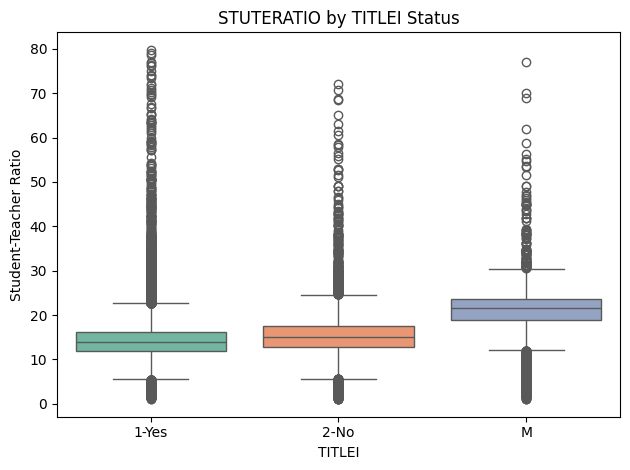

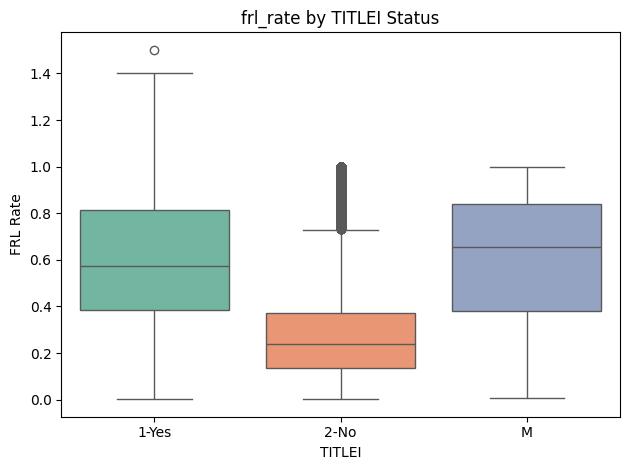

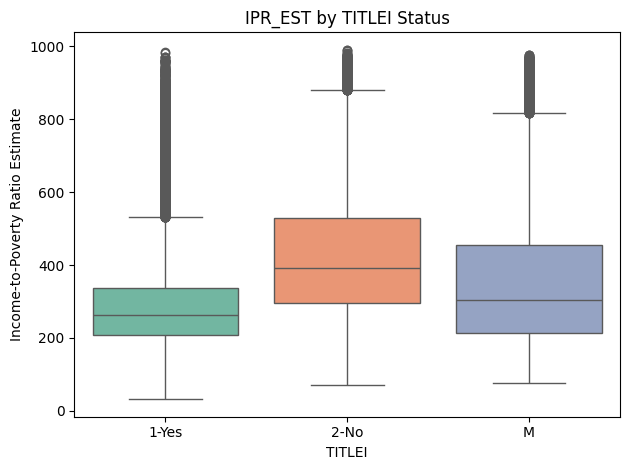

In [47]:
# Boxplots for TITLEI vs student-teacher ratio, free lunch rate, and income-to-poverty ratio
boxplot_titlei(edu_qual_df, 'STUTERATIO', 'Student-Teacher Ratio')
boxplot_titlei(edu_qual_df, 'frl_rate', 'FRL Rate')
boxplot_titlei(edu_qual_df, 'IPR_EST', 'Income-to-Poverty Ratio Estimate')

**Observation:**

The boxplot indicates a strong relationship between Title I eligibility and higher free or reduced lunch rates. Schools marked as Title I or missing a Title I designation show higher median frl_rate values compared to non-Title I schools. This pattern aligns with expectations, as Title I funding targets economically disadvantaged populations. The distribution also shows greater variability among Title I schools, reflecting a broader range of need within that group.

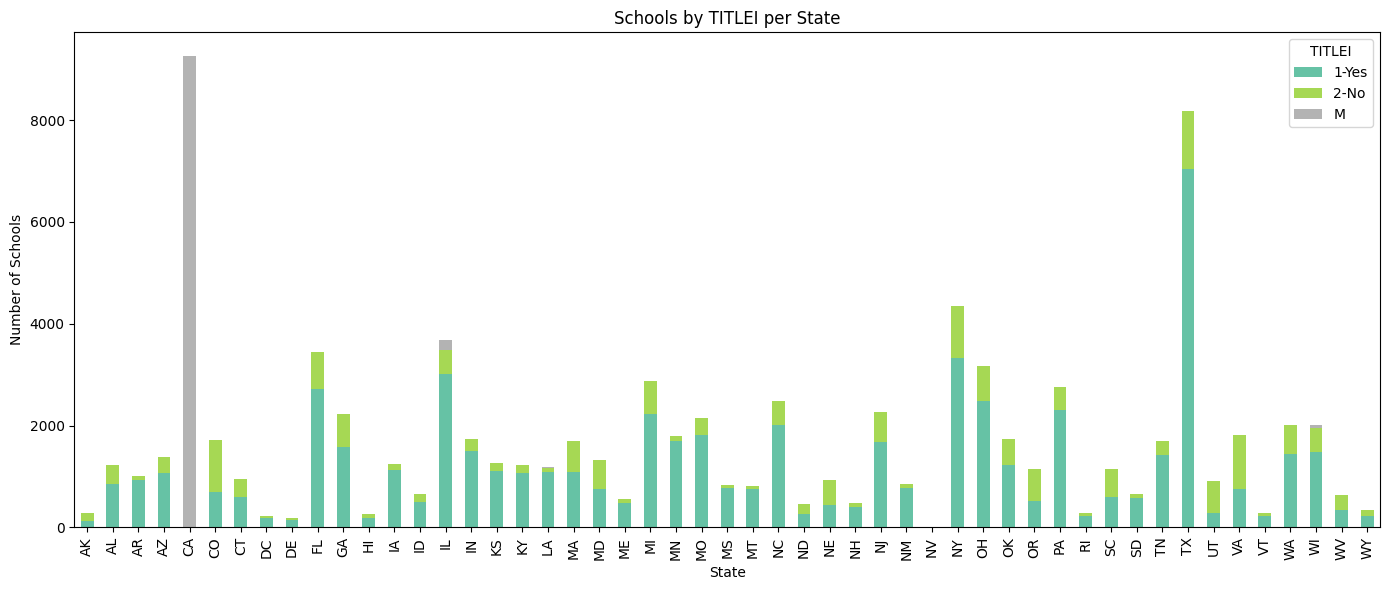

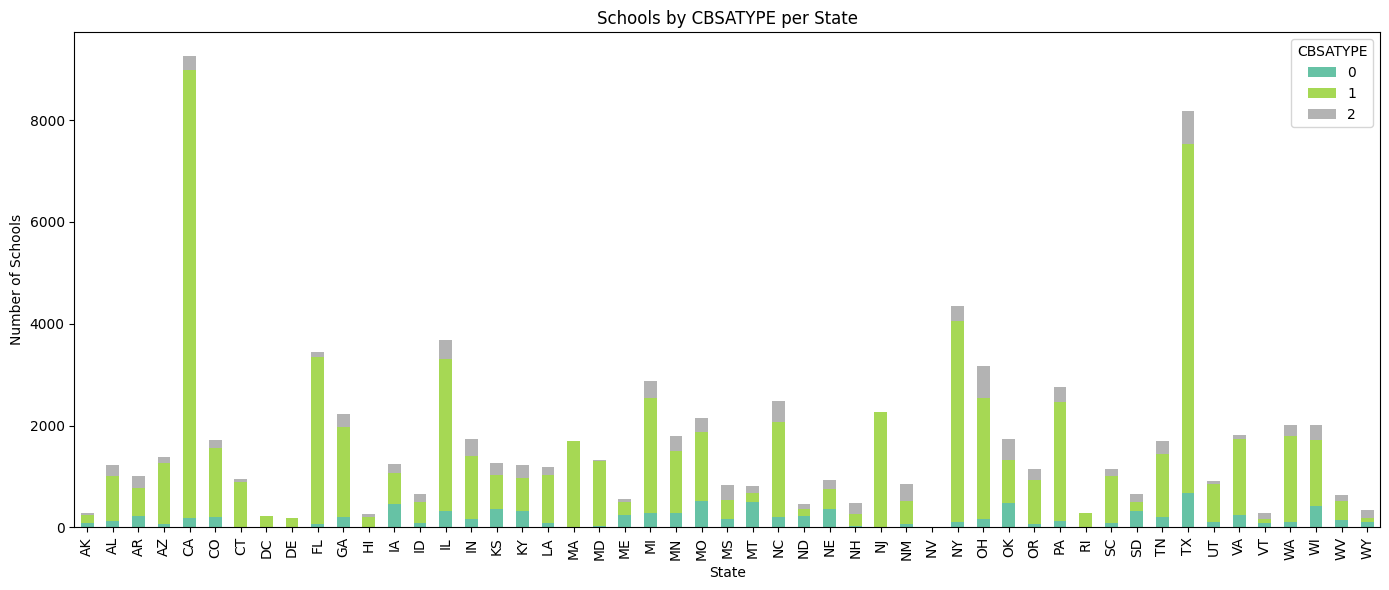

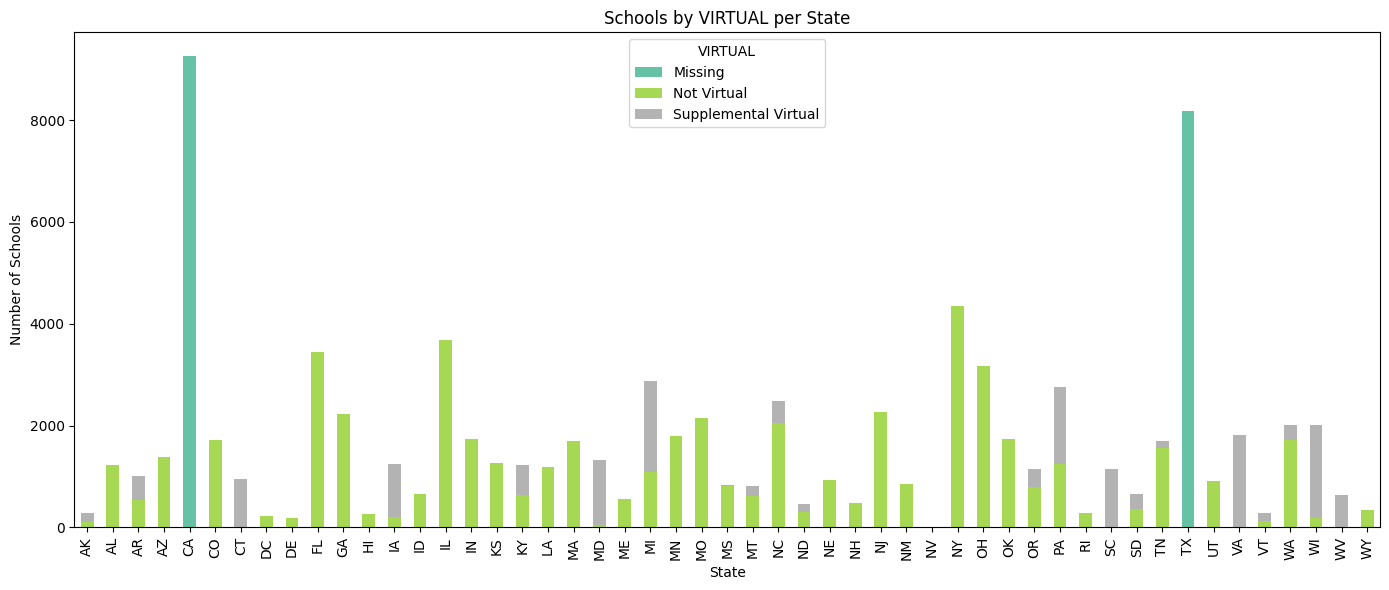

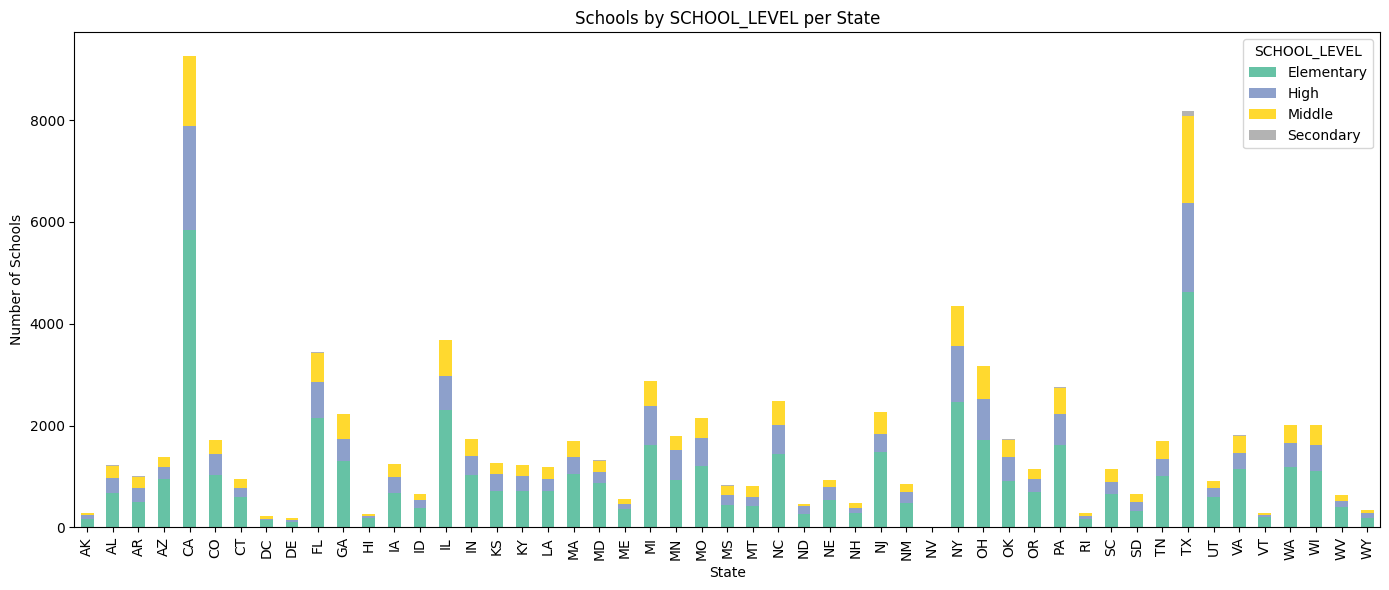

In [48]:
# Stacked barplots for categorical attributes across states by TITLEI, CBSATYPE, virtual status, and school level
plot_state_stacked_bars(edu_qual_df, ['TITLEI', 'CBSATYPE', 'VIRTUAL', 'SCHOOL_LEVEL'])

**Observation:**

Most schools are classified as 'Not Virtual,' with smaller but still notable counts of 'Supplemental Virtual' programs across many states. California and Texas have disproportionately large numbers of records marked as 'Missing' for the virtual status field, which may reflect reporting gaps rather than actual school format. These missing values could skew interpretations if not addressed in geographic or structural comparisons.

In [49]:
# Filter schools in California with TITLEI marked as "M"
ca_titlei_missing = edu_qual_df[(edu_qual_df['STATE'] == 'CA') & (edu_qual_df['TITLEI'] == 'M')]

# Display count and a sample of records
print(f"Number of CA schools with TITLEI='M': {len(ca_titlei_missing)}")
display(ca_titlei_missing[['NAME', 'CITY', 'TITLEI', 'SCHOOL_LEVEL']].head())


Number of CA schools with TITLEI='M': 9257


NAME     CITY TITLEI SCHOOL_LEVEL
3843           Vasquez High    Acton      M         High
3844  Meadowlark Elementary    Acton      M   Elementary
3845            High Desert    Acton      M       Middle
3846       Manor Elementary  Fairfax      M   Elementary
3847      White Hill Middle  Fairfax      M       Middle

In [50]:
# Separate CA schools with TITLEI == 'M'
ca_missing_titlei = edu_qual_df[(edu_qual_df['STATE'] == 'CA') & (edu_qual_df['TITLEI'] == 'M')]
non_ca_or_valid_titlei = edu_qual_df[~((edu_qual_df['STATE'] == 'CA') & (edu_qual_df['TITLEI'] == 'M'))]

# Summary statistics for each group
summary_columns = ['frl_rate', 'IPR_EST', 'LEA_CWIFTEST']
ca_summary = ca_missing_titlei[summary_columns].describe().T
non_ca_summary = non_ca_or_valid_titlei[summary_columns].describe().T

# Combine for comparison
comparison_summary = ca_summary[['mean', 'std', 'min', '25%', '50%', '75%', 'max']].copy()
comparison_summary.columns = [f'CA_{col}' for col in comparison_summary.columns]

for col in ['mean', 'std', 'min', '25%', '50%', '75%', 'max']:
    comparison_summary[f'Other_{col}'] = non_ca_summary[col]

comparison_summary.round(3)

CA_mean   CA_std  CA_min   CA_25%   CA_50%   CA_75%   CA_max  \
frl_rate        0.603    0.270   0.008    0.388    0.657    0.838    0.997   
IPR_EST       364.937  200.237  76.000  214.000  305.000  458.000  977.000   
LEA_CWIFTEST    1.119    0.109   0.858    1.071    1.101    1.143    1.431   

              Other_mean  Other_std  Other_min  Other_25%  Other_50%  \
frl_rate           0.518      0.283      0.002      0.287      0.492   
IPR_EST          322.764    152.684     32.000    220.000    285.000   
LEA_CWIFTEST       0.915      0.106      0.593      0.838      0.901   

              Other_75%  Other_max  
frl_rate          0.750      1.501  
IPR_EST         383.000    990.000  
LEA_CWIFTEST      0.975      1.272

In [51]:
# Recode TITLEI == 'M' to 'Unknown'
edu_qual_df['TITLEI'] = edu_qual_df['TITLEI'].replace('M', 'Unknown')

**Explanation:**

California's over 9,200 missing TITLEI status values coded as 'M', which likely stands for 'Missing' are a large portion of the dataset and could skew interpretations if left unclassified. By separating out these records and comparing them to all other schools, the summary reveals that California's 'M' group has higher average free or reduced lunch rates, higher neighborhood poverty estimates, and significantly higher CWIFT scores, suggesting these schools may still reflect high need populations despite the missing designation.

To retain these observations without misleading the model or visualizations, the 'M' values are recoded as 'Unknown'. This avoids dropping thousands of records while maintaining transparency about the lack of Title I data. The resulting group can be handled as a separate category in one-hot encoding, preserving its potential signal without introducing false assumptions.

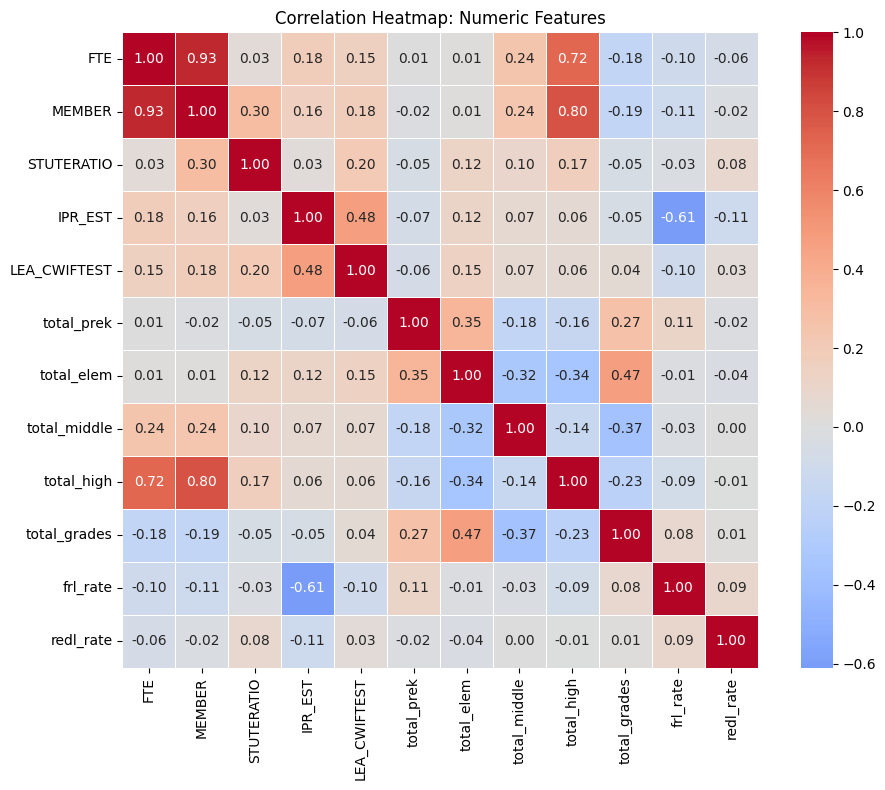

In [52]:
# Isolate relevlant numeric features to visualize correlation
heatmap_features = ['FTE', 'MEMBER', 'STUTERATIO', 'IPR_EST', 'LEA_CWIFTEST',
                    'total_prek', 'total_elem', 'total_middle', 'total_high', 'total_grades',
                    'frl_rate', 'redl_rate']
corr_matrix_selected = edu_qual_df[heatmap_features].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix_selected, annot=True, fmt=".2f", cmap='coolwarm', center=0, square=True, linewidths=0.5)
plt.title('Correlation Heatmap: Numeric Features')
plt.tight_layout()
plt.show()

In [53]:
# Drop grade band totals and FTE and MEMBER to reduce redundancy
edu_qual_df.drop(columns=['total_prek', 'total_elem', 'total_middle', 'total_high',
    'FTE', 'MEMBER'], inplace=True)

**Observation:**

The correlation heatmap indicates few strong relationships and many weak ones. FTE and MEMBER are almost perfectly correlated, and both show strong positive correlation with total_high, indicating redundancy among staffing and high school enrollment metrics. IPR_EST and frl_rate are moderately negatively correlated, which aligns with expectations since higher neighborhood poverty often corresponds with more students qualifying for free or reduced lunch. STUTERATIO shows only weak correlations with most features, suggesting it's influenced by a wide mix of factors rather than a single dominant one.

Grade band totals are moderately correlated with total_grades, and many are interrelated, especially at the elementary level. Dropping FTE, MEMBER, and the grade band totals helps reduce multicollinearity and redundancy, keeping the core structural and economic signals intact.

In [54]:
# Final Premodeling dataframe
edu_qual_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 85825 entries, 0 to 85824
Data columns (total 20 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   NCESSCH       85825 non-null  int64  
 1   X             85825 non-null  float64
 2   Y             85825 non-null  float64
 3   NAME          85825 non-null  object 
 4   CITY          85825 non-null  object 
 5   STATE         85825 non-null  object 
 6   NMCNTY        85825 non-null  object 
 7   CBSATYPE      85825 non-null  int64  
 8   LEAID         85825 non-null  float64
 9   LEA_NAME      85825 non-null  object 
 10  VIRTUAL       85825 non-null  object 
 11  SCHOOL_LEVEL  85825 non-null  object 
 12  TITLEI        85825 non-null  object 
 13  ULOCALE       85825 non-null  object 
 14  STUTERATIO    85825 non-null  float64
 15  IPR_EST       85825 non-null  float64
 16  LEA_CWIFTEST  79813 non-null  float64
 17  total_grades  85825 non-null  int64  
 18  frl_rate      72829 non-nu

In [55]:
# Drop columns not used for modeling
edu_qual_model_df = edu_qual_df.drop(columns=[
    'NCESSCH',      # unique ID
    'X', 'Y',       # lat/long
    'NAME',         # school name
    'CITY',         # city
    'LEAID',        # district ID
    'LEA_NAME',     # district
    'NMCNTY',       # county
    'STATE'         # state
])

**Explanation:**

These columns are dropped because they either serve as unique identifiers or represent geographic labels, reducing noise, dimenstionality, and keeping the dataset focused on predictive structural and contextual features.

In [56]:
# Final modeling attributes
edu_qual_model_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 85825 entries, 0 to 85824
Data columns (total 11 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   CBSATYPE      85825 non-null  int64  
 1   VIRTUAL       85825 non-null  object 
 2   SCHOOL_LEVEL  85825 non-null  object 
 3   TITLEI        85825 non-null  object 
 4   ULOCALE       85825 non-null  object 
 5   STUTERATIO    85825 non-null  float64
 6   IPR_EST       85825 non-null  float64
 7   LEA_CWIFTEST  79813 non-null  float64
 8   total_grades  85825 non-null  int64  
 9   frl_rate      72829 non-null  float64
 10  redl_rate     67147 non-null  float64
dtypes: float64(5), int64(2), object(4)
memory usage: 7.2+ MB


### **Data Preparation**

In [57]:
# Train-test split for modeling
# Taking the log of the target variable
X = edu_qual_model_df.drop(columns='STUTERATIO')
y = np.log1p(edu_qual_model_df['STUTERATIO'])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

**Explanation:**

Training and test split with 20 percent held out for evaluation.

The target variable, STUTERATIO, is log-transformed using np.log1p to reduce skewness and improve model stability. This transformation will address the wide range of values and outliers, allowing the models to better capture underlying patterns in student-teacher ratios.

### **Model Selection**

In [58]:
# Define a set of imputers to handle missing values
imputers = {
    'SimpleMedian': SimpleImputer(strategy='median'),
    'Iterative': IterativeImputer(random_state=42),
}

# Define a set of scalers and transformers for feature normalization
scalers = {
    'Standard': StandardScaler(),
    'Robust': RobustScaler(),
    'Power': PowerTransformer(method='yeo-johnson')
}

# Define a collection of regression models to evaluate
regressors = {
    'Ridge': Ridge(),
    'ElasticNet': ElasticNet(),
    'RandomForest': RandomForestRegressor(random_state=42),
    'GradientBoosting': GradientBoostingRegressor(random_state=42),
    'HistGB': HistGradientBoostingRegressor(random_state=42),
    'XGBoost': XGBRegressor(random_state=42, verbosity=0)
}

**Explanation:**

Initial models produced weak results. To explore multiple preprocessing and modeling strategies, a range of imputers, scalers, and regressors were used in an effort to find a combination that improves performance.

Two imputation methods are included: a simple median imputer for robust baseline handling of missing values and an iterative imputer that models missing values based on relationships with other features.

The scalers include standard normalization, robust scaling for outlier resistance, and power transformation to reduce skewness.

The regressors span from linear and ensemble-based models, from Ridge and ElasticNet to tree-based algorithms like Random Forest, Gradient Boosting, and XGBoost.

In [59]:
# Loop through all combinations of imputer, scaler, and regression model
results = []

for imp_name, imp in imputers.items():
    for sc_name, sc in scalers.items():
        for reg_name, reg in regressors.items():
            label = f'{reg_name} | {imp_name} | {sc_name}'

            # Build and evaluate the pipeline with the selected components
            pipeline = build_model_pipeline(reg, imputer=imp, scaler=sc)
            scores = evaluate_model(pipeline, X_train, y_train, label)
            results.append(scores)

            print(f"{label} → R²: {scores['R²']:.3f}, RMSE: {scores['RMSE']:.3f}, MAE: {scores['MAE']:.3f}, MedianAE: {scores['MedianAE']:.3f}", flush=True)

Ridge | SimpleMedian | Standard → R²: 0.215, RMSE: 18.826, MAE: 2.912, MedianAE: 2.166
ElasticNet | SimpleMedian | Standard → R²: -0.020, RMSE: 24.446, MAE: 3.458, MedianAE: 2.545
RandomForest | SimpleMedian | Standard → R²: 0.885, RMSE: 2.766, MAE: 0.913, MedianAE: 0.613
GradientBoosting | SimpleMedian | Standard → R²: 0.282, RMSE: 17.217, MAE: 2.730, MedianAE: 2.008
HistGB | SimpleMedian | Standard → R²: 0.367, RMSE: 15.181, MAE: 2.526, MedianAE: 1.857
XGBoost | SimpleMedian | Standard → R²: 0.479, RMSE: 12.503, MAE: 2.257, MedianAE: 1.636
Ridge | SimpleMedian | Robust → R²: 0.215, RMSE: 18.826, MAE: 2.912, MedianAE: 2.166
ElasticNet | SimpleMedian | Robust → R²: -0.020, RMSE: 24.446, MAE: 3.458, MedianAE: 2.545
RandomForest | SimpleMedian | Robust → R²: 0.885, RMSE: 2.766, MAE: 0.913, MedianAE: 0.613
GradientBoosting | SimpleMedian | Robust → R²: 0.282, RMSE: 17.217, MAE: 2.730, MedianAE: 2.008
HistGB | SimpleMedian | Robust → R²: 0.367, RMSE: 15.181, MAE: 2.526, MedianAE: 1.857
XGB

In [60]:
results_df = pd.DataFrame(results).sort_values(by='R²', ascending=False)
display(results_df)


Model        R²       RMSE       MAE  \
20         RandomForest | Iterative | Standard  0.885594   2.742992  0.914835   
32            RandomForest | Iterative | Power  0.885537   2.744361  0.914977   
26           RandomForest | Iterative | Robust  0.885461   2.746203  0.915064   
8         RandomForest | SimpleMedian | Robust  0.884630   2.766119  0.912946   
2       RandomForest | SimpleMedian | Standard  0.884615   2.766474  0.912956   
14         RandomForest | SimpleMedian | Power  0.884614   2.766501  0.913125   
35                 XGBoost | Iterative | Power  0.480415  12.457586  2.270833   
23              XGBoost | Iterative | Standard  0.480415  12.457586  2.270833   
29                XGBoost | Iterative | Robust  0.480415  12.457586  2.270833   
17              XGBoost | SimpleMedian | Power  0.478504  12.503404  2.257343   
11             XGBoost | SimpleMedian | Robust  0.478504  12.503404  2.257343   
5            XGBoost | SimpleMedian | Standard  0.478504  12.503404  2.257343   
10              HistGB | SimpleMedian | Robust  0.366826  15.181008  2.525512   
4             HistGB | SimpleMedian | Standard  0.366826  15.181008  2.525512   
16               HistGB | SimpleMedian | Power  0.366826  15.181008  2.525512   
22               HistGB | Iterative | Standard  0.361838  15.300600  2.540804   
34                  HistGB | Iterative | Power  0.361838  15.300600  2.540804   
28                 HistGB | Iterative | Robust  0.361838  15.300600  2.540804   
3   GradientBoosting | SimpleMedian | Standard  0.281904  17.217103  2.729726   
9     GradientBoosting | SimpleMedian | Robust  0.281904  17.217103  2.729726   
15     GradientBoosting | SimpleMedian | Power  0.281904  17.217103  2.729726   
21     GradientBoosting | Iterative | Standard  0.279612  17.272054  2.734793   
27       GradientBoosting | Iterative | Robust  0.279612  17.272054  2.734793   
33        GradientBoosting | Iterative | Power  0.279612  17.272054  2.734793   
6                Ridge | SimpleMedian | Robust  0.214804  18.825892  2.911641   
0              Ridge | SimpleMedian | Standard  0.214804  18.825893  2.911641   
12                Ridge | SimpleMedian | Power  0.214614  18.830441  2.912981   
30                   Ridge | Iterative | Power  0.214348  18.836823  2.912365   
24                  Ridge | Iterative | Robust  0.214321  18.837468  2.911953   
18                Ridge | Iterative | Standard  0.214321  18.837469  2.911954   
1         ElasticNet | SimpleMedian | Standard -0.019603  24.446038  3.458040   
7           ElasticNet | SimpleMedian | Robust -0.019603  24.446038  3.458040   
19           ElasticNet | Iterative | Standard -0.019603  24.446038  3.458040   
13           ElasticNet | SimpleMedian | Power -0.019603  24.446038  3.458040   
25             ElasticNet | Iterative | Robust -0.019603  24.446038  3.458040   
31              ElasticNet | Iterative | Power -0.019603  24.446038  3.458040   

    MedianAE  
20  0.613594  
32  0.613687  
26  0.614045  
8   0.612820  
2   0.612670  
14  0.612488  
35  1.655555  
23  1.655555  
29  1.655555  
17  1.635647  
11  1.635647  
5   1.635647  
10  1.857476  
4   1.857476  
16  1.857476  
22  1.866562  
34  1.866562  
28  1.866562  
3   2.008462  
9   2.008462  
15  2.008462  
21  2.007632  
27  2.007632  
33  2.007632  
6   2.166169  
0   2.166180  
12  2.172618  
30  2.173185  
24  2.169259  
18  2.169248  
1   2.545300  
7   2.545300  
19  2.545300  
13  2.545300  
25  2.545300  
31  2.545300

**Observation:**

The model comparison shows a clear performance gap between tree based methods and linear models. Random Forest consistently delivered the highest R² values across all preprocessing combinations, with scores around 0.885 and very low RMSE and MAE, indicating a strong fit to the training data. XGBoost followed, with significantly lower performance but still well ahead of other models. HistGradientBoosting and GradientBoosting performed moderately, while Ridge and ElasticNet lagged behind, especially ElasticNet, which failed to produce meaningful predictions across the board. Given their relative strengths, Random Forest and XGBoost will be tuned and evaluated further to determine which model generalizes best to the test data.

### **Model Tuning**

#### **XGBoost**

In [84]:
# Define hyperparameter grid for tuning the XGBoost regressor
xgb_params = {
    'regressor__n_estimators': [100, 200, 300],
    'regressor__learning_rate': [0.01, 0.05, 0.1, 0.2],
    'regressor__max_depth': [3, 5, 7, 10],
    'regressor__subsample': [0.6, 0.8, 1.0],
    'regressor__colsample_bytree': [0.6, 0.8, 1.0],
    'regressor__reg_alpha': [0, 0.1, 1],
    'regressor__reg_lambda': [1, 3, 5]
}
# Build XGBoost pipeline with selected imputer and scaler
xgb_pipeline = build_model_pipeline(
    model=XGBRegressor(objective='reg:squarederror', random_state=42, verbosity=0),
    imputer=IterativeImputer(random_state=42),
    scaler=PowerTransformer(method='yeo-johnson')
)

**Explanation:**

A hyperparameter grid is defined to explore tuning options for XGBoost, including tree depth, learning rate, subsampling ratios, and regularization terms. A pipeline is then built using median imputation and standard scaling to ensure consistent preprocessing before fitting the model. This structure supports efficient and reliable tuning during cross-validation.

In [85]:
# Perform randomized search to tune XGBoost hyperparameters
xgb_search = RandomizedSearchCV(
    estimator=xgb_pipeline,
    param_distributions=xgb_params,
    n_iter=25,
    scoring='r2',
    cv=3,
    verbose=1,
    random_state=42,
    n_jobs=-1
)
# Fit the search object on the training data
xgb_search.fit(X_train, y_train)

Fitting 3 folds for each of 25 candidates, totalling 75 fits


RandomizedSearchCV(cv=3,
                   estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(transformers=[('log_num',
                                                                               Pipeline(steps=[('imputer',
                                                                                                IterativeImputer(random_state=42)),
                                                                                               ('log',
                                                                                                FunctionTransformer(func=<ufunc 'log1p'>)),
                                                                                               ('scaler',
                                                                                                PowerTransformer())]),
                                                                               ['IPR_EST',
                                                                                'frl_rate',
                                                                                'redl_rate']),
                                                                              ('num',
                                                                               Pipeline(steps=[('imputer',
                                                                                                IterativeImputer(random_stat...
                                                           random_state=42, ...))]),
                   n_iter=25, n_jobs=-1,
                   param_distributions={'regressor__colsample_bytree': [0.6,
                                                                        0.8,
                                                                        1.0],
                                        'regressor__learning_rate': [0.01, 0.05,
                                                                     0.1, 0.2],
                                        'regressor__max_depth': [3, 5, 7, 10],
                                        'regressor__n_estimators': [100, 200,
                                                                    300],
                                        'regressor__reg_alpha': [0, 0.1, 1],
                                        'regressor__reg_lambda': [1, 3, 5],
                                        'regressor__subsample': [0.6, 0.8,
                                                                 1.0]},
                   random_state=42, scoring='r2', verbose=1)

In [99]:
# Retrieve the best pipeline configuration from the search
xgb_search.best_params_

{'regressor__subsample': 1.0,
 'regressor__reg_lambda': 3,
 'regressor__reg_alpha': 1,
 'regressor__n_estimators': 100,
 'regressor__max_depth': 10,
 'regressor__learning_rate': 0.2,
 'regressor__colsample_bytree': 0.6}

In [100]:
# Predict on the test set using the best tuned XGBoost pipeline
best_xgb_pipeline = xgb_search.best_estimator_
y_pred_log = best_xgb_pipeline.predict(X_test)
y_pred = np.expm1(y_pred_log)
y_actual = np.expm1(y_test)

# Evaluate model performance on the test set
print("XGBoost Tuned Test Performance:")
print(f"R²:       {r2_score(y_actual, y_pred):.3f}")
print(f"RMSE:     {mean_squared_error(y_actual, y_pred):.3f}")
print(f"MAE:      {mean_absolute_error(y_actual, y_pred):.3f}")
print(f"MedianAE: {median_absolute_error(y_actual, y_pred):.3f}")

XGBoost Tuned Test Performance:
R²:       0.387
RMSE:     14.328
MAE:      2.427
MedianAE: 1.717


**Observation:**

The tuned XGBoost model selected a fairly aggressive configuration, with a high learning rate of 0.2, max_depth=10, and strong regularization, reg_alpha=1 and reg_lambda=3. While this setup achieved solid results during tuning, its test performance a R² of 0.387, RMSE of 14.33, and MAE of 2.43 reflects only moderate generalization. The model captures meaningful structure in the data but still leaves significant residual error. The performance drop from earlier training R² at 0.48 indicates the need for a model with stronger generalization.

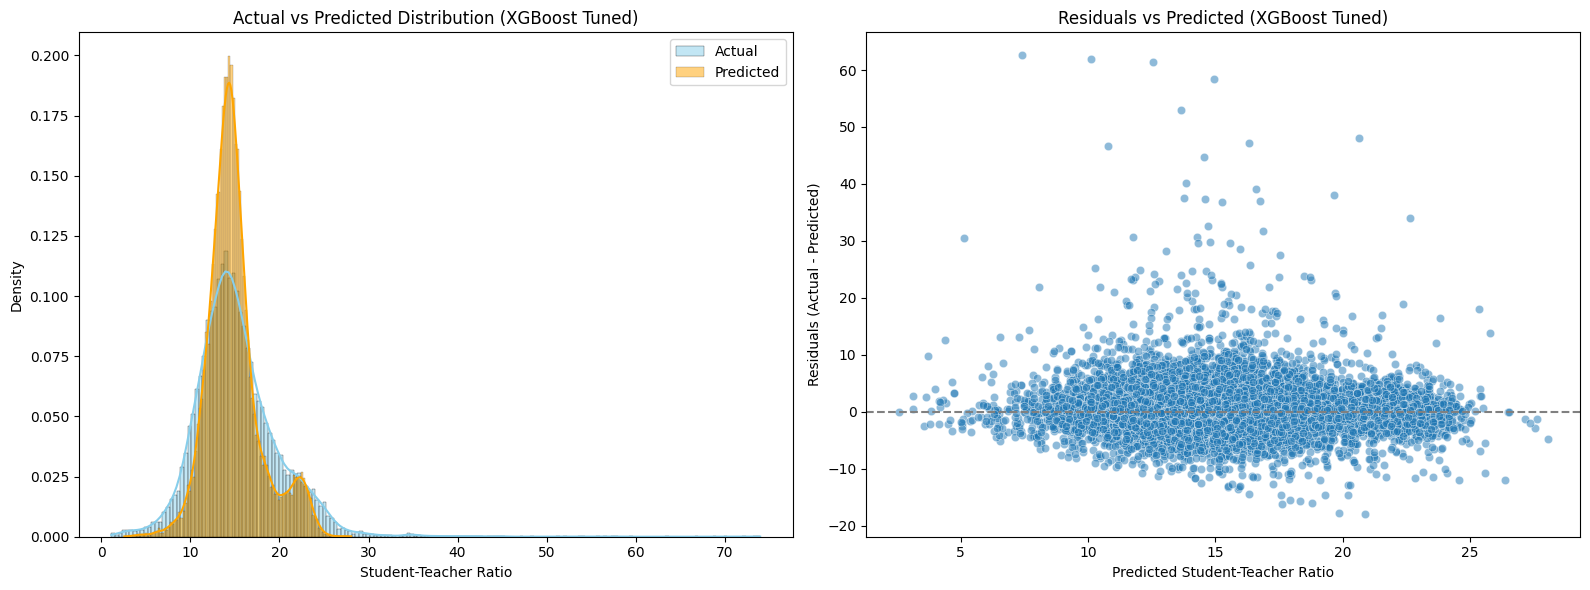

In [65]:
# Predict on log scale and inverse-transform
xgb_preds_log = best_xgb_pipeline.predict(X_test)
xgb_preds = np.expm1(xgb_preds_log)
y_actual = np.expm1(y_test)
xgb_residuals = y_actual - xgb_preds

# Set up subplots
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Distribution
sns.histplot(y_actual, color='skyblue', label='Actual', kde=True, stat='density', ax=axes[0])
sns.histplot(xgb_preds, color='orange', label='Predicted', kde=True, stat='density', ax=axes[0])
axes[0].set_title('Actual vs Predicted Distribution (XGBoost Tuned)')
axes[0].set_xlabel('Student-Teacher Ratio')
axes[0].legend()

# Residuals vs Predicted
sns.scatterplot(x=xgb_preds, y=xgb_residuals, alpha=0.5, ax=axes[1])
axes[1].axhline(0, color='gray', linestyle='--')
axes[1].set_title('Residuals vs Predicted (XGBoost Tuned)')
axes[1].set_xlabel('Predicted Student-Teacher Ratio')
axes[1].set_ylabel('Residuals (Actual - Predicted)')
plt.tight_layout()
plt.show()

**Observation:**

The actual vs predicted student-teacher ratios from the tuned XGBoost model closely follow the distribution of the actual values, especially around the central peak, indicating that the model captures the dominant trend well. Although the residuals shows a slight funnel shape and vertical spread, particularly at higher predicted values, suggesting that the model's error increases with larger ratios and that variance is not entirely stable across the range.

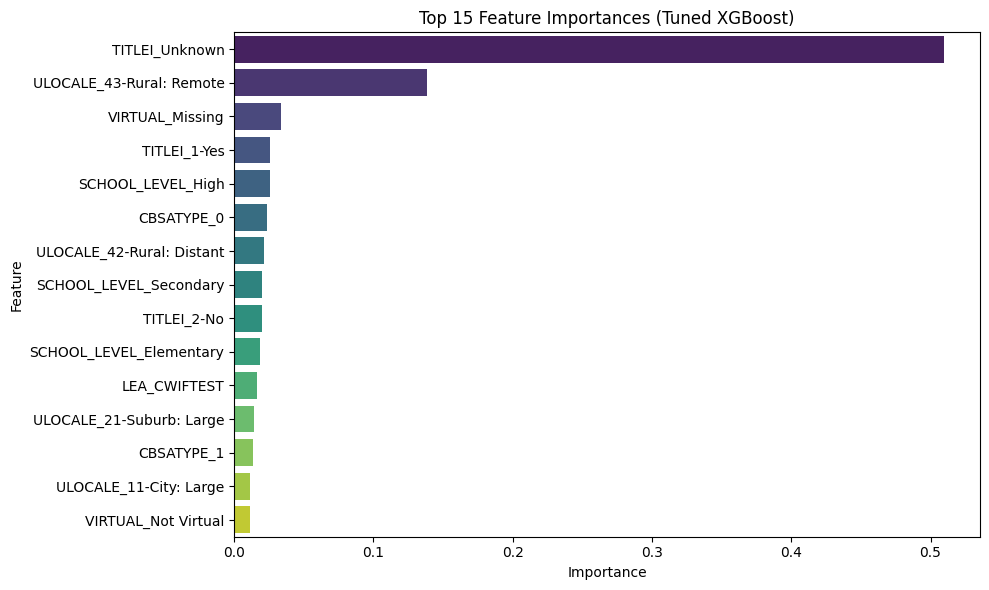

In [66]:
# Extract the fitted preprocessor and regressor from the best XGBoost pipeline
xgb_preprocessor = best_xgb_pipeline.named_steps['preprocessor']
xgb_regressor = best_xgb_pipeline.named_steps['regressor']

# Get feature names from each part of the preprocessor
xgb_log_features = xgb_preprocessor.named_transformers_['log_num'].named_steps['scaler'].get_feature_names_out(
    ['IPR_EST', 'frl_rate', 'redl_rate']
)
xgb_num_features = ['LEA_CWIFTEST', 'total_grades']
xgb_cat_features = xgb_preprocessor.named_transformers_['cat'].named_steps['encoder'].get_feature_names_out(
    ['CBSATYPE', 'VIRTUAL', 'SCHOOL_LEVEL', 'TITLEI', 'ULOCALE']
)

xgb_feature_names = list(chain(xgb_log_features, xgb_num_features, xgb_cat_features))

# Get feature importances from the trained model
xgb_importances = xgb_regressor.feature_importances_
xgb_importances_df = pd.DataFrame({
    'Feature': xgb_feature_names,
    'Importance': xgb_importances
}).sort_values(by='Importance', ascending=False)

# Plot the top features
plt.figure(figsize=(10, 6))
sns.barplot(data=xgb_importances_df.head(15), x='Importance', y='Feature', palette='viridis')
plt.title("Top 15 Feature Importances (Tuned XGBoost)")
plt.xlabel("Importance")
plt.tight_layout()
plt.show()

**Observation:**

The top features from the tuned XGBoost are dominated by categorical indicators, with TITLEI_Unknown (California) and ULOCALE_43-Rural: Remote standing out strongly. This suggests the model is heavily relying on structural and location-based context rather than continuous metrics, emphasizing the predictive weight of missing or categorical school attributes in explaining variation in student-teacher ratios.

#### **Random Forest**

In [67]:
# Define hyperparameter grid for tuning the Random Forest regressor
rf_params = {
    'regressor__n_estimators': [100, 200, 300],
    'regressor__max_depth': [None, 10, 20, 30],
    'regressor__min_samples_split': [2, 5, 10],
    'regressor__min_samples_leaf': [1, 2, 4],
    'regressor__max_features': ['sqrt', 0.8, None],
    'regressor__bootstrap': [True, False]
}
# Build Random Forest pipeline with selected imputer and scaler
rf_pipeline = build_model_pipeline(
    model=RandomForestRegressor(random_state=42, n_jobs=-1),
    imputer=SimpleImputer(strategy='median'),
    scaler=StandardScaler()
)

In [68]:
# Perform randomized search to tune Random Forest hyperparameters
rf_search = RandomizedSearchCV(
    estimator=rf_pipeline,
    param_distributions=rf_params,
    n_iter=25,
    scoring='r2',
    cv=3,
    verbose=1,
    random_state=42,
    n_jobs=-1
)

rf_search.fit(X_train, y_train)

Fitting 3 folds for each of 25 candidates, totalling 75 fits


RandomizedSearchCV(cv=3,
                   estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(transformers=[('log_num',
                                                                               Pipeline(steps=[('imputer',
                                                                                                SimpleImputer(strategy='median')),
                                                                                               ('log',
                                                                                                FunctionTransformer(func=<ufunc 'log1p'>)),
                                                                                               ('scaler',
                                                                                                StandardScaler())]),
                                                                               ['IPR_EST',
                                                                                'frl_rate',
                                                                                'redl_rate']),
                                                                              ('num',
                                                                               Pipeline(steps=[('imputer',
                                                                                                SimpleImputer(strategy='median'...
                                              RandomForestRegressor(n_jobs=-1,
                                                                    random_state=42))]),
                   n_iter=25, n_jobs=-1,
                   param_distributions={'regressor__bootstrap': [True, False],
                                        'regressor__max_depth': [None, 10, 20,
                                                                 30],
                                        'regressor__max_features': ['sqrt', 0.8,
                                                                    None],
                                        'regressor__min_samples_leaf': [1, 2,
                                                                        4],
                                        'regressor__min_samples_split': [2, 5,
                                                                         10],
                                        'regressor__n_estimators': [100, 200,
                                                                    300]},
                   random_state=42, scoring='r2', verbose=1)

In [69]:
# Retrieve the best pipeline configuration from the search
rf_search.best_params_

{'regressor__n_estimators': 300,
 'regressor__min_samples_split': 2,
 'regressor__min_samples_leaf': 2,
 'regressor__max_features': 0.8,
 'regressor__max_depth': 30,
 'regressor__bootstrap': True}

In [70]:
# Predict on the test set using the best tuned Random Forest pipeline
best_rf_pipeline = rf_search.best_estimator_

y_pred_log = best_rf_pipeline.predict(X_test)
y_pred = np.expm1(y_pred_log)
y_actual = np.expm1(y_test)

# Evaluate model performance on the test set
print("Random Forest Tuned Test Performance:")
print(f"R²:       {r2_score(y_actual, y_pred):.3f}")
print(f"RMSE:     {mean_squared_error(y_actual, y_pred):.3f}")
print(f"MAE:      {mean_absolute_error(y_actual, y_pred):.3f}")
print(f"MedianAE: {median_absolute_error(y_actual, y_pred):.3f}")


Random Forest Tuned Test Performance:
R²:       0.399
RMSE:     14.061
MAE:      2.384
MedianAE: 1.664


**Observation:**

The tuned Random Forest model achieved slightly stronger test performance than XGBoost, with a test R² of 0.399 and a lower RMSE and MAE. The configuration's depth and feature flexibility, allow trees to grow fairly large while using only 80% of features per split. This setup appears to better capture variation in student-teacher ratios, suggesting that Random Forest may generalize more effectively for this problem than gradient boosting.

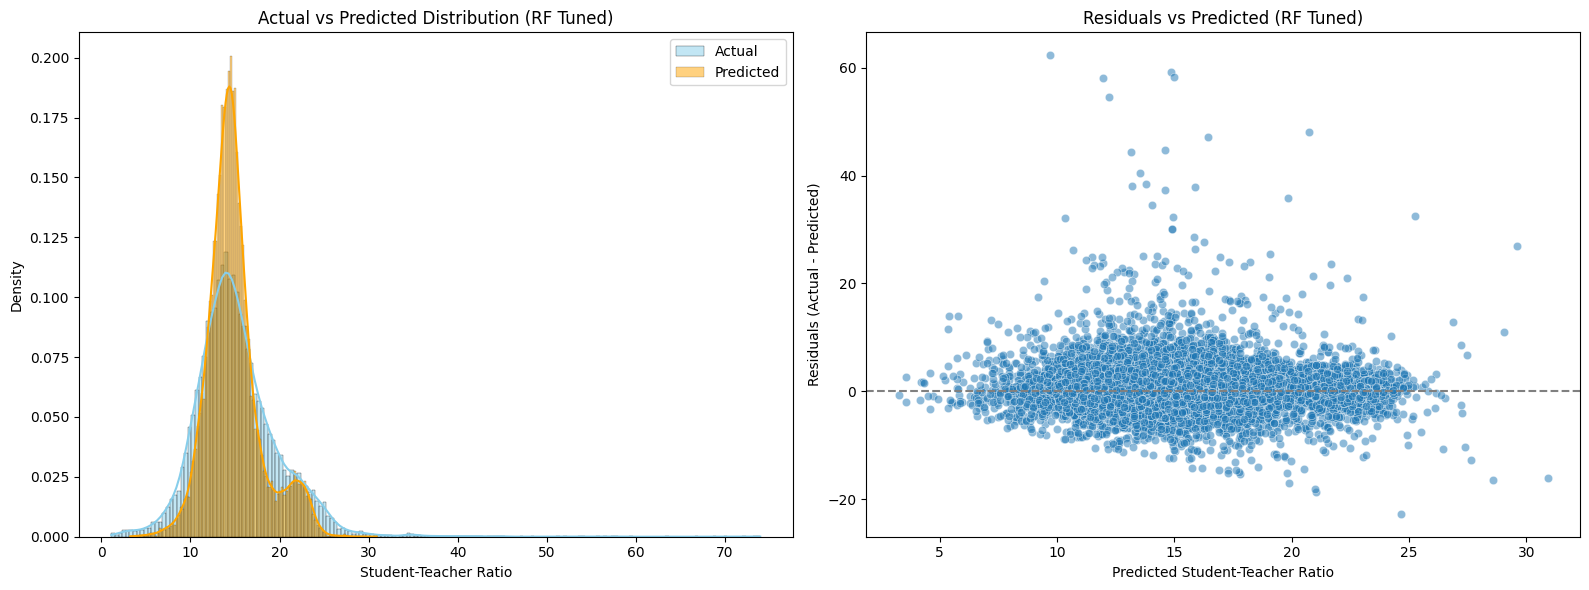

In [71]:
# Make sure rf_preds and y_actual are inverse-transformed
rf_preds_log = best_rf_pipeline.predict(X_test)
rf_preds = np.expm1(rf_preds_log)
y_actual = np.expm1(y_test)
rf_residuals = y_actual - rf_preds

# Set up subplots
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Distribution
sns.histplot(y_actual, color='skyblue', label='Actual', kde=True, stat='density', ax=axes[0])
sns.histplot(rf_preds, color='orange', label='Predicted', kde=True, stat='density', ax=axes[0])
axes[0].set_title('Actual vs Predicted Distribution (RF Tuned)')
axes[0].set_xlabel('Student-Teacher Ratio')
axes[0].legend()

# Residuals vs Predicted
sns.scatterplot(x=rf_preds, y=rf_residuals, alpha=0.5, ax=axes[1])
axes[1].axhline(0, color='gray', linestyle='--')
axes[1].set_title('Residuals vs Predicted (RF Tuned)')
axes[1].set_xlabel('Predicted Student-Teacher Ratio')
axes[1].set_ylabel('Residuals (Actual - Predicted)')
plt.tight_layout()
plt.show()


**Observation:**

The tuned Random Forest model matches the actual student-teacher ratio distribution. Residuals are fairly evenly spread across predicted values, with no strong bias, though variance increases slightly at the extremes, consistent with earlier observations about model limitations.

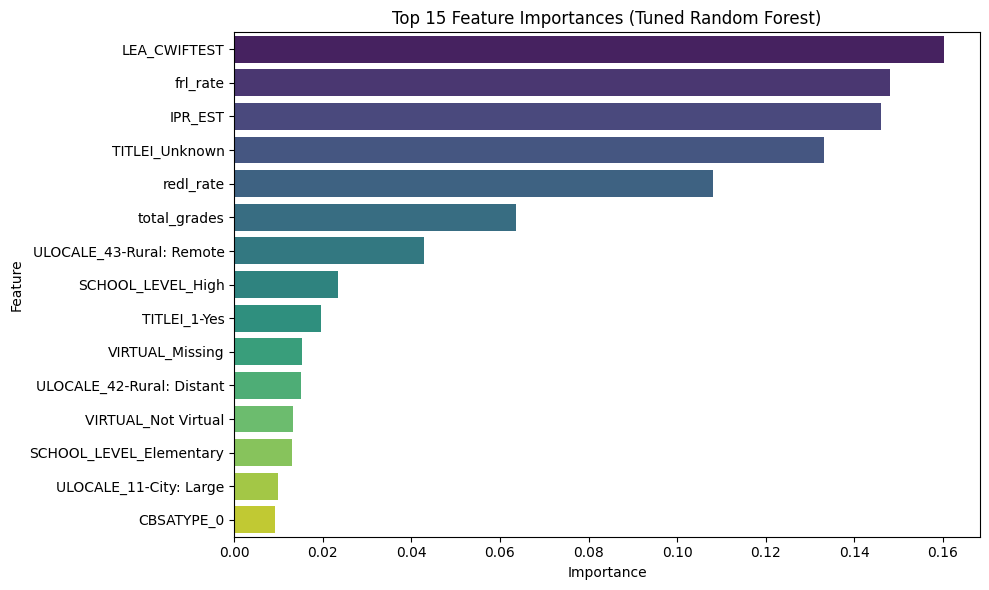

In [72]:
# Extract the fitted preprocessor and regressor from the best RF pipeline
rf_preprocessor = best_rf_pipeline.named_steps['preprocessor']
rf_regressor = best_rf_pipeline.named_steps['regressor']

# Get feature names from each of the preprocessor
rf_log_features = rf_preprocessor.named_transformers_['log_num'].named_steps['scaler'].get_feature_names_out(
    ['IPR_EST', 'frl_rate', 'redl_rate']
)
rf_num_features = ['LEA_CWIFTEST', 'total_grades']
rf_cat_features = rf_preprocessor.named_transformers_['cat'].named_steps['encoder'].get_feature_names_out(
    ['CBSATYPE', 'VIRTUAL', 'SCHOOL_LEVEL', 'TITLEI', 'ULOCALE']
)

rf_feature_names = list(chain(rf_log_features, rf_num_features, rf_cat_features))

# Get feature importances from the trained model
rf_importances = rf_regressor.feature_importances_
rf_importances_df = pd.DataFrame({
    'Feature': rf_feature_names,
    'Importance': rf_importances
}).sort_values(by='Importance', ascending=False)

# Plot top features
plt.figure(figsize=(10, 6))
sns.barplot(data=rf_importances_df.head(15), x='Importance', y='Feature', palette='viridis')
plt.title("Top 15 Feature Importances (Tuned Random Forest)")
plt.xlabel("Importance")
plt.tight_layout()
plt.show()


**Observation:**

The Random Forest model places the highest importance on CWIFT wage competitiveness, lunch eligibility, income estimates, and Title I status—all key structural and economic indicators. Compared to XGBoost, it emphasizes more continuous variables and less on encoded labels, suggesting that RF leverages core socioeconomic features more heavily in its predictions.

In [101]:
# Predict on training set (log scale)
xgb_train_log_preds = best_xgb_pipeline.predict(X_train)
xgb_train_actual = np.expm1(y_train)
xgb_train_preds = np.expm1(xgb_train_log_preds)

# R² on original scale
xgb_train_r2 = r2_score(xgb_train_actual, xgb_train_preds)

rf_train_log_preds = best_rf_pipeline.predict(X_train)
rf_train_actual = np.expm1(y_train)
rf_train_preds = np.expm1(rf_train_log_preds)

rf_train_r2 = r2_score(rf_train_actual, rf_train_preds)

In [103]:
# Provide evaluation metrics for both models
summary_df = pd.DataFrame({
    'Model': ['XGBoost Tuned', 'Random Forest Tuned'],
    'R² (Train)': [xgb_train_r2, rf_train_r2],
    'R² (Test)': [0.387, 0.399],
    'RMSE (Test)': [14.328, 14.061],
    'MAE (Test)': [2.427, 2.384],
    'Median AE (Test)': [1.717, 1.664]
})

summary_df.round(3)

Model  R² (Train)  R² (Test)  RMSE (Test)  MAE (Test)  \
0        XGBoost Tuned       0.576      0.387       14.328       2.427   
1  Random Forest Tuned       0.777      0.399       14.061       2.384   

   Median AE (Test)  
0             1.717  
1             1.664

**Observation:**

The tuned Random Forest model delivered the strongest overall performance, achieving the highest R² on the test set at 0.399 while maintaining a lower RMSE, MAE, and Median AE compared to the tuned XGBoost model. Although its training R² was higher than XGBoost's, the gap between train and test scores remained moderate, suggesting the model generalized reasonably well. This consistent performance across metrics makes Random Forest the best performing model for predicting student-teacher ratios in this dataset.

### **Unsupervised Learning**

In [75]:
# Select features for unsupervised analysis
unsup_features = ['IPR_EST', 'frl_rate', 'redl_rate', 'LEA_CWIFTEST', 'total_grades']
unsup_categorical = ['SCHOOL_LEVEL', 'CBSATYPE', 'ULOCALE']

# Build preprocessing pipeline
unsup_preprocessor = ColumnTransformer(transformers=[
    ('num', Pipeline([
        ('imputer', SimpleImputer(strategy='median')),
        ('scaler', StandardScaler())
    ]), unsup_features),
    ('cat', OneHotEncoder(handle_unknown='ignore'), unsup_categorical)
])

# Apply preprocessing
X_unsup = unsup_preprocessor.fit_transform(edu_qual_model_df)

In [76]:
# PCA dimensionality reduction
pca = PCA(n_components=15, random_state=42)
X_pca = pca.fit_transform(X_unsup)

# t-SNE to 2D
tsne = TSNE(n_components=2, perplexity=30, random_state=42)
X_tsne = tsne.fit_transform(X_pca)

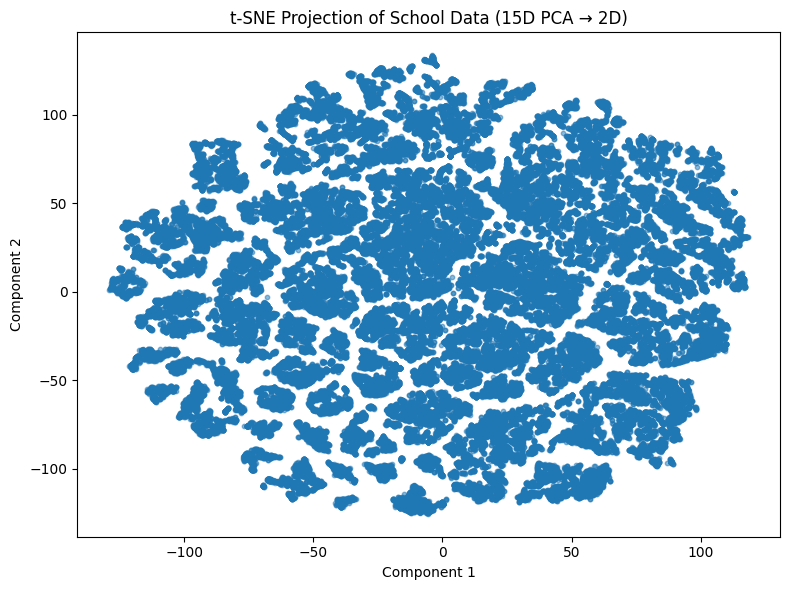

In [77]:
# Visualize t-SNE projection
plt.figure(figsize=(8, 6))
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], alpha=0.5, s=10)
plt.title('t-SNE Projection of School Data (15D PCA → 2D)')
plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.tight_layout()
plt.show()

**Observation:**

The t-SNE projection reveals clear structure in the high-dimensional school data, even without clustering applied yet. The space is densely filled but not uniform, there are distinct pockets and shapes that suggest natural grouping tendencies.

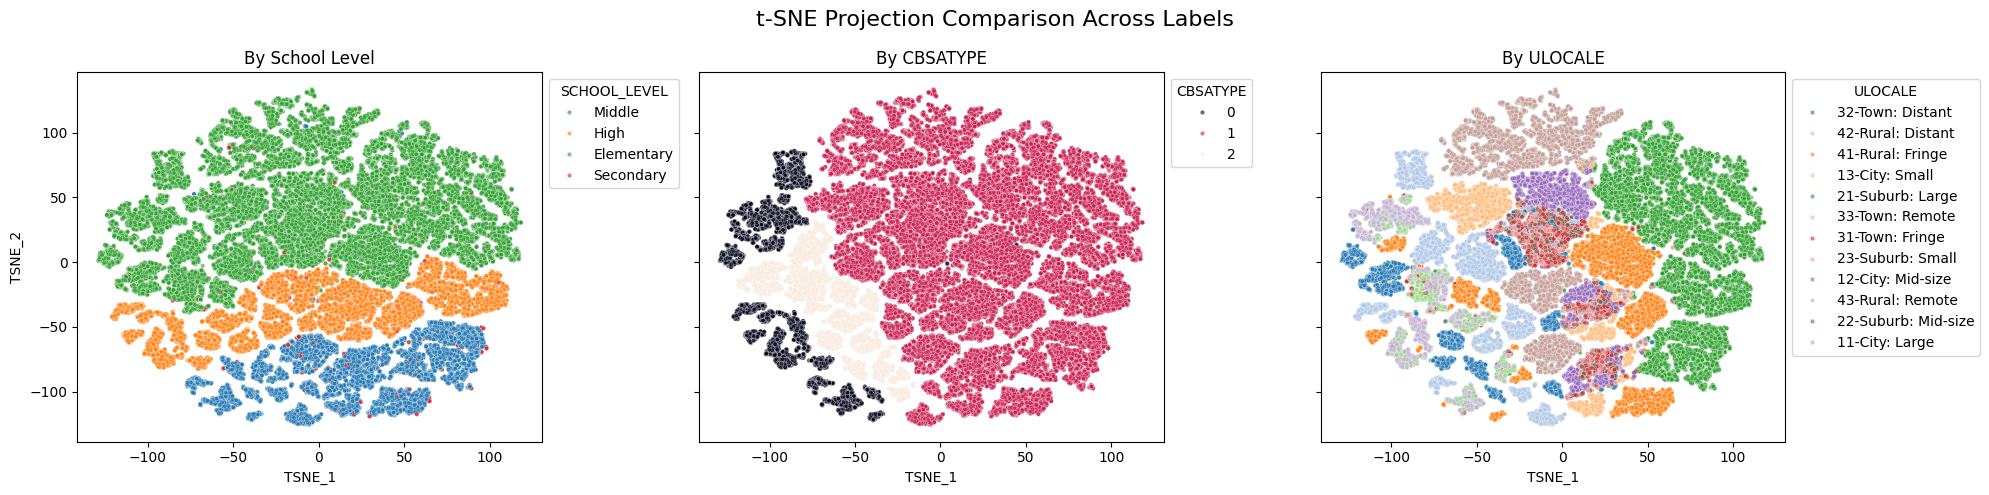

In [78]:
# Add all label columns to the DataFrame
tsne_df = pd.DataFrame(X_tsne, columns=['TSNE_1', 'TSNE_2'])
tsne_df['SCHOOL_LEVEL'] = edu_qual_model_df['SCHOOL_LEVEL'].values
tsne_df['CBSATYPE'] = edu_qual_model_df['CBSATYPE'].values
tsne_df['ULOCALE'] = edu_qual_model_df['ULOCALE'].values

# Set up the subplots
fig, axes = plt.subplots(1, 3, figsize=(20, 5), sharex=True, sharey=True)
fig.suptitle('t-SNE Projection Comparison Across Labels', fontsize=16)

# SCHOOL_LEVEL
sns.scatterplot(data=tsne_df, x='TSNE_1', y='TSNE_2', hue='SCHOOL_LEVEL', ax=axes[0], s=10, alpha=0.6)
axes[0].set_title("By School Level")
axes[0].legend(title='SCHOOL_LEVEL', bbox_to_anchor=(1, 1), loc='upper left')

# CBSATYPE
sns.scatterplot(data=tsne_df, x='TSNE_1', y='TSNE_2', hue='CBSATYPE', ax=axes[1], s=10, alpha=0.6, palette='rocket')
axes[1].set_title("By CBSATYPE")
axes[1].legend(title='CBSATYPE', bbox_to_anchor=(1, 1), loc='upper left')

# ULOCALE
sns.scatterplot(data=tsne_df, x='TSNE_1', y='TSNE_2', hue='ULOCALE', ax=axes[2], s=10, alpha=0.6, palette='tab20')
axes[2].set_title("By ULOCALE")
axes[2].legend(title='ULOCALE', bbox_to_anchor=(1, 1), loc='upper left')

plt.tight_layout()
plt.show()

**Observation:**

The t-SNE projection reveals distinct structure across all three categorical labels. School level appears well-separated, especially between elementary and high schools, suggesting grade configuration is a strong differentiator. CBSATYPE clusters show more overlap but still maintain some regional consistency between metro, micro, and rural types.

The clearest patterns emerge from ULOCALE, where geographic setting visibly aligns with the spatial distribution, reinforcing that physical context plays a key role in shaping school characteristics. This validates the feature set used and supports clustering as a meaningful next step.

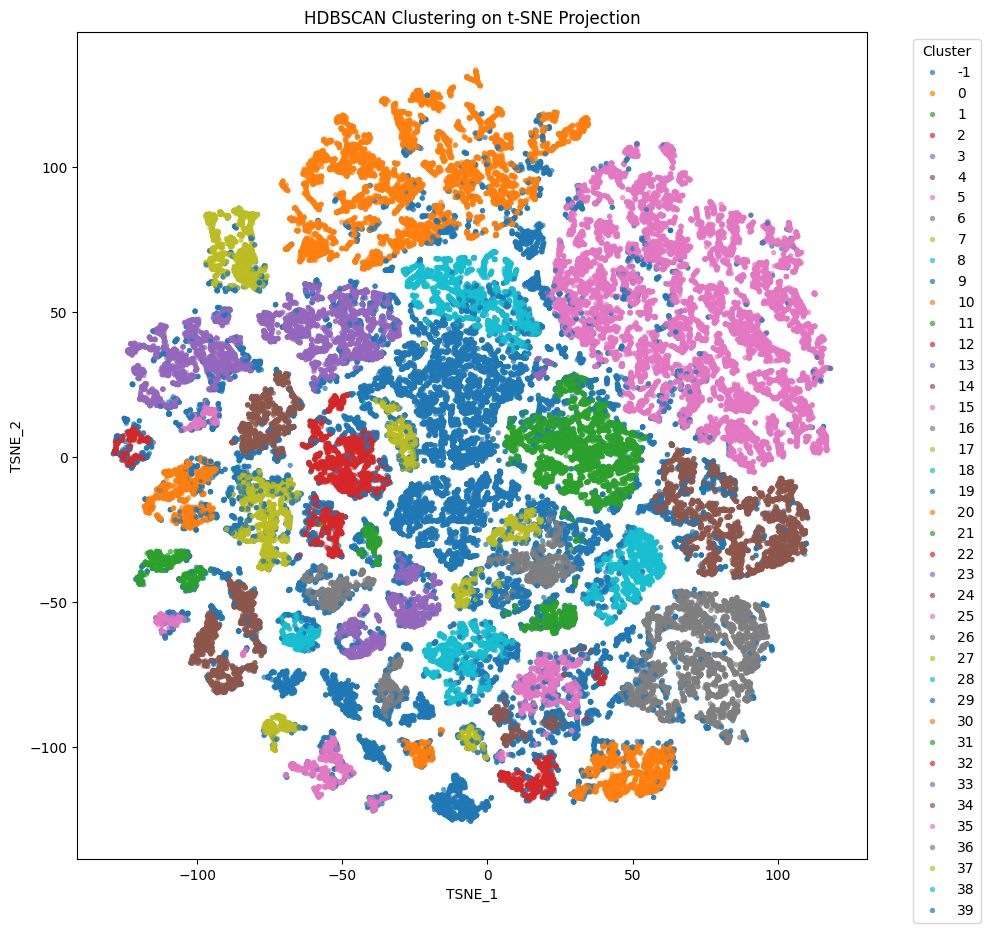

In [79]:
# Run HDBSCAN on PCA-transformed data
hdb = hdbscan.HDBSCAN(min_cluster_size=300, min_samples=10, prediction_data=True)
hdb_labels = hdb.fit_predict(X_pca)

# Add labels to tsne_df
tsne_df['HDBSCAN_Cluster'] = hdb_labels

# Plot clusters (noise points are labeled -1)
plt.figure(figsize=(10, 10))
sns.scatterplot(
    data=tsne_df,
    x='TSNE_1',
    y='TSNE_2',
    hue='HDBSCAN_Cluster',
    palette='tab10',
    s=15,
    linewidth=0,
    alpha=0.7
)
plt.title('HDBSCAN Clustering on t-SNE Projection')
plt.legend(title='Cluster', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

**Observation:**

The HDBSCAN clustering over the t-SNE projection reveals compact groups that closely mirror the structure seen when coloring by ULOCALE. This suggests that locale is a major underlying driver of variation in the dataset and that HDBSCAN is effectively capturing geographic and structural differences without explicitly using ULOCALE as a label. The strength of this alignment reinforces that the selected features carry meaningful context and that the unsupervised approach is surfacing real, interpretable patterns.

In [94]:
pd.crosstab(edu_qual_model_df['HDBSCAN_Cluster'], edu_qual_model_df['ULOCALE'])


ULOCALE          11-City: Large  12-City: Mid-size  13-City: Small  \
HDBSCAN_Cluster                                                      
-1                         1869               1493            1055   
 0                            0                  0               0   
 1                            0                  0               0   
 2                            0                  0               0   
 3                            0                  0               0   
 4                            0                  0               0   
 5                            0                  0               0   
 6                            0                  0               0   
 7                            0                  0               0   
 8                            0                  0               0   
 9                            0                  0               0   
 10                           0                  0               0   
 11                           0                  0               0   
 12                           0                  0               0   
 13                           0                  0               0   
 14                           0                  0               0   
 15                           0                  0               0   
 16                           0                  0               0   
 17                           0                  0               0   
 18                           0                  0               0   
 19                           0                  0               0   
 20                           0                  0               0   
 21                           0                  0               0   
 22                           0                  0               0   
 23                           0                  0               0   
 24                           0                  0               0   
 25                           0                  0               0   
 26                           0                  0               0   
 27                           0                  0               0   
 28                        1483                  0               0   
 29                        2065                  0               0   
 30                        7341                  0               0   
 31                           0                  0             696   
 32                           0                  0             690   
 33                           0                  0            2874   
 34                           0                489               0   
 35                           0                  0               0   
 36                           0                  0               0   
 37                           0                543               0   
 38                           0               2469               0   
 39                           0                  0               0   

ULOCALE          21-Suburb: Large  22-Suburb: Mid-size  23-Suburb: Small  \
HDBSCAN_Cluster                                                            
-1                           1613                  562               358   
 0                              0                    0                 0   
 1                              0                    0                 0   
 2                              0                    0                 0   
 3                              0                    0                 0   
 4                              0                    0                 0   
 5                              0                    0                 0   
 6                              0                    3                 2   
 7                              0                    0                 0   
 8                              0                    0                 0   
 9                              0                    0                 0   
 

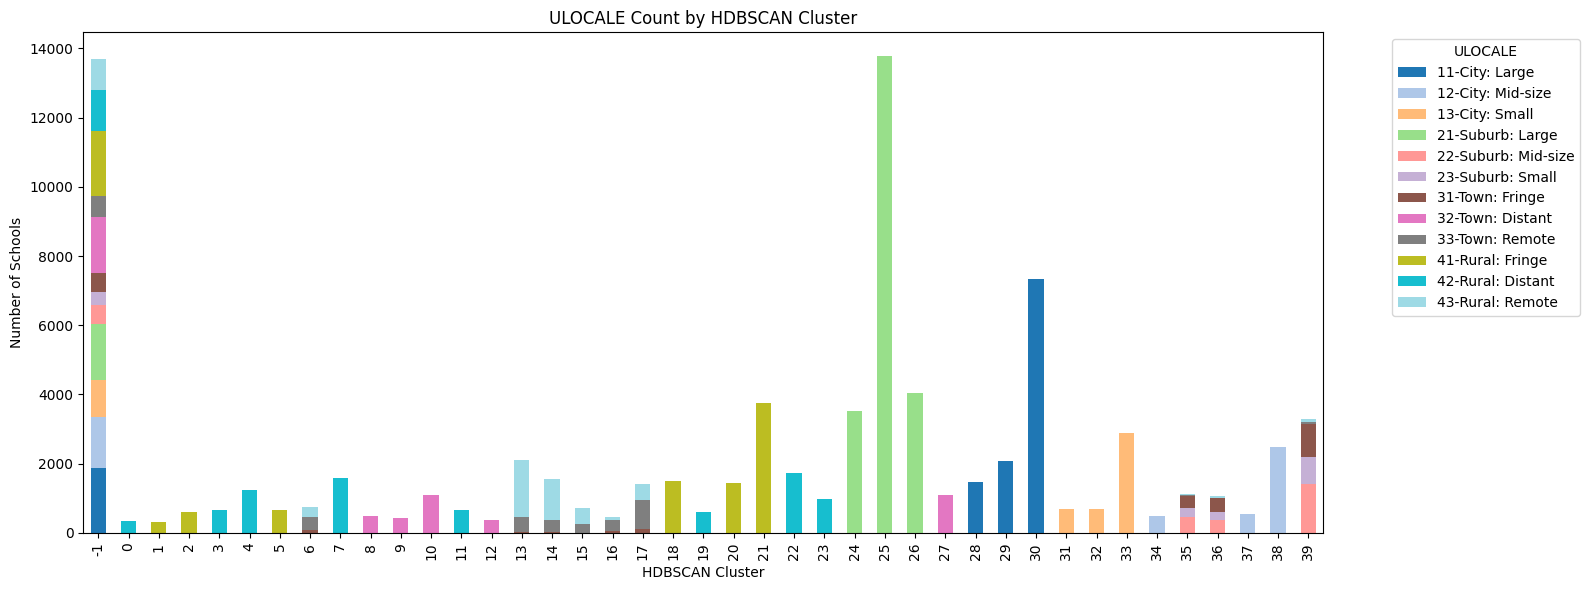

In [98]:
# Create crosstab of counts
crosstab_counts = pd.crosstab(tsne_df['HDBSCAN_Cluster'], tsne_df['ULOCALE'])

# Plot stacked bar chart of counts
crosstab_counts.plot(kind='bar', stacked=True, figsize=(16, 6), colormap='tab20')
plt.title('ULOCALE Count by HDBSCAN Cluster')
plt.xlabel('HDBSCAN Cluster')
plt.ylabel('Number of Schools')
plt.legend(title='ULOCALE', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

**Observation:**

The ULOCALE distribution across HDBSCAN clusters confirms the earlier observation that many clusters reflect geographic and community patterns. Several clusters are made up almost entirely of a single locale type, for example, Cluster 25 is overwhelmingly composed of '21-Suburb: Large' schools, while Cluster 29 is dominated by '11-City: Large.' This clarity in composition underscores that HDBSCAN is effectively capturing structural groupings present in the data without being told about ULOCALE directly. These patterns suggest that cluster membership could be used as a proxy for localized educational conditions, which has potential value for targeted analysis and policy design.

## **Conclusion**

This project combined supervised modeling and unsupervised clustering to explore patterns in public school staffing across the U.S. Using an enriched NCES dataset, the goal was to predict student-teacher ratios and uncover structural groupings of schools that might inform policy.

Supervised regression models, including tuned versions of XGBoost and Random Forest, achieved modest predictive accuracy, with Random Forest performing slightly better on the test set. While the overall R² values were not high, the results were consistent, and both models captured some real signal from features tied to funding competitiveness, poverty, and school characteristics.

Unsupervised learning revealed even more striking patterns. The combination of PCA, t-SNE, and HDBSCAN uncovered dozens of natural clusters, many of which closely mirrored known locale categories. These clusters emerged without using ULOCALE as input, suggesting that structural conditions embedded in the data reliably reflect geographic and socioeconomic divides.

Together, the findings support the idea that student-teacher ratios are influenced by deeper systemic factors and that clustering can help identify those patterns. This lays the groundwork for targeted, regionally informed decisions and strategies in education.